In [7]:
import matplotlib.pyplot as plt

import numpy as np
import pandas as pd
import gc
import time
from contextlib import contextmanager
from lightgbm import LGBMClassifier
from sklearn.metrics import roc_auc_score, roc_curve
from sklearn.model_selection import KFold, StratifiedKFold
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler

import xgboost as xgb
from xgboost import XGBRegressor
from sklearn.metrics import make_scorer
from sklearn.metrics import fbeta_score
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import r2_score
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler

import mlflow
from sklearn.metrics import roc_auc_score, confusion_matrix, accuracy_score, recall_score, f1_score, roc_auc_score
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.dummy import DummyClassifier
from xgboost import XGBClassifier

from sklearn.preprocessing import MinMaxScaler
from sklearn.pipeline import make_pipeline
from imblearn.pipeline import Pipeline as ImbPipeline
from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import RandomOverSampler

from sklearn.model_selection import StratifiedKFold

import time
import black

from evidently.report import Report
from evidently.metric_preset import DataDriftPreset, TargetDriftPreset
from evidently.metrics import *


In [8]:
@contextmanager
def timer(title):
    t0 = time.time()
    yield
    print("{} - done in {:.0f}s".format(title, time.time() - t0))

# One-hot encoding for categorical columns with get_dummies
def one_hot_encoder(df, nan_as_category = True):
    original_columns = list(df.columns)
    categorical_columns = [col for col in df.columns if df[col].dtype == 'object']
    df = pd.get_dummies(df, columns= categorical_columns, dummy_na= nan_as_category)
    new_columns = [c for c in df.columns if c not in original_columns]
    return df, new_columns

# Preprocess application_train.csv and application_test.csv
def application_train_test(num_rows = None, nan_as_category = False):
    # Read data and merge
    df = pd.read_csv('application_train.csv', nrows= num_rows)
    test_df = pd.read_csv('application_test.csv', nrows= num_rows)
    print("Train samples: {}, test samples: {}".format(len(df), len(test_df)))
    
    #df = df.append(test_df).reset_index(drop=True)
    df = pd.concat([df, pd.DataFrame(test_df)], ignore_index=True)
    # Optional: Remove 4 applications with XNA CODE_GENDER (train set)
    df = df[df['CODE_GENDER'] != 'XNA']
   
    
    # Categorical features with Binary encode (0 or 1; two categories)
    for bin_feature in ['CODE_GENDER', 'FLAG_OWN_CAR', 'FLAG_OWN_REALTY']:
        df[bin_feature], uniques = pd.factorize(df[bin_feature])
    # Categorical features with One-Hot encode
    df, cat_cols = one_hot_encoder(df, nan_as_category)
    
    # NaN values for DAYS_EMPLOYED: 365.243 -> nan
    df['DAYS_EMPLOYED'].replace(365243, np.nan, inplace= True)
    # Some simple new features (percentages)
    df['DAYS_EMPLOYED_PERC'] = df['DAYS_EMPLOYED'] / df['DAYS_BIRTH']
    df['INCOME_CREDIT_PERC'] = df['AMT_INCOME_TOTAL'] / df['AMT_CREDIT']
    df['INCOME_PER_PERSON'] = df['AMT_INCOME_TOTAL'] / df['CNT_FAM_MEMBERS']
    df['ANNUITY_INCOME_PERC'] = df['AMT_ANNUITY'] / df['AMT_INCOME_TOTAL']
    df['PAYMENT_RATE'] = df['AMT_ANNUITY'] / df['AMT_CREDIT']
    del test_df
    gc.collect()
    return df

# Preprocess bureau.csv and bureau_balance.csv
def bureau_and_balance(num_rows = None, nan_as_category = True):
    bureau = pd.read_csv('bureau.csv', nrows = num_rows)
    bb = pd.read_csv('bureau_balance.csv', nrows = num_rows)
    bb, bb_cat = one_hot_encoder(bb, nan_as_category)
    bureau, bureau_cat = one_hot_encoder(bureau, nan_as_category)
    
    # Bureau balance: Perform aggregations and merge with bureau.csv
    bb_aggregations = {'MONTHS_BALANCE': ['min', 'max', 'size']}
    for col in bb_cat:
        bb_aggregations[col] = ['mean']
    bb_agg = bb.groupby('SK_ID_BUREAU').agg(bb_aggregations)
    bb_agg.columns = pd.Index([e[0] + "_" + e[1].upper() for e in bb_agg.columns.tolist()])
    bureau = bureau.join(bb_agg, how='left', on='SK_ID_BUREAU')
    bureau.drop(['SK_ID_BUREAU'], axis=1, inplace= True)
    del bb, bb_agg
    gc.collect()
    
    # Bureau and bureau_balance numeric features
    num_aggregations = {
        'DAYS_CREDIT': ['min', 'max', 'mean', 'var'],
        'DAYS_CREDIT_ENDDATE': ['min', 'max', 'mean'],
        'DAYS_CREDIT_UPDATE': ['mean'],
        'CREDIT_DAY_OVERDUE': ['max', 'mean'],
        'AMT_CREDIT_MAX_OVERDUE': ['mean'],
        'AMT_CREDIT_SUM': ['max', 'mean', 'sum'],
        'AMT_CREDIT_SUM_DEBT': ['max', 'mean', 'sum'],
        'AMT_CREDIT_SUM_OVERDUE': ['mean'],
        'AMT_CREDIT_SUM_LIMIT': ['mean', 'sum'],
        'AMT_ANNUITY': ['max', 'mean'],
        'CNT_CREDIT_PROLONG': ['sum'],
        'MONTHS_BALANCE_MIN': ['min'],
        'MONTHS_BALANCE_MAX': ['max'],
        'MONTHS_BALANCE_SIZE': ['mean', 'sum']
    }
    # Bureau and bureau_balance categorical features
    cat_aggregations = {}
    for cat in bureau_cat: cat_aggregations[cat] = ['mean']
    for cat in bb_cat: cat_aggregations[cat + "_MEAN"] = ['mean']
    
    bureau_agg = bureau.groupby('SK_ID_CURR').agg({**num_aggregations, **cat_aggregations})
    bureau_agg.columns = pd.Index(['BURO_' + e[0] + "_" + e[1].upper() for e in bureau_agg.columns.tolist()])
    # Bureau: Active credits - using only numerical aggregations
    active = bureau[bureau['CREDIT_ACTIVE_Active'] == 1]
    active_agg = active.groupby('SK_ID_CURR').agg(num_aggregations)
    active_agg.columns = pd.Index(['ACTIVE_' + e[0] + "_" + e[1].upper() for e in active_agg.columns.tolist()])
    bureau_agg = bureau_agg.join(active_agg, how='left', on='SK_ID_CURR')
    del active, active_agg
    gc.collect()
    # Bureau: Closed credits - using only numerical aggregations
    closed = bureau[bureau['CREDIT_ACTIVE_Closed'] == 1]
    closed_agg = closed.groupby('SK_ID_CURR').agg(num_aggregations)
    closed_agg.columns = pd.Index(['CLOSED_' + e[0] + "_" + e[1].upper() for e in closed_agg.columns.tolist()])
    bureau_agg = bureau_agg.join(closed_agg, how='left', on='SK_ID_CURR')
    del closed, closed_agg, bureau
    gc.collect()
    return bureau_agg

# Preprocess previous_applications.csv
def previous_applications(num_rows = None, nan_as_category = True):
    prev = pd.read_csv('previous_application.csv', nrows = num_rows)
    prev, cat_cols = one_hot_encoder(prev, nan_as_category= True)
    # Days 365.243 values -> nan
    prev['DAYS_FIRST_DRAWING'].replace(365243, np.nan, inplace= True)
    prev['DAYS_FIRST_DUE'].replace(365243, np.nan, inplace= True)
    prev['DAYS_LAST_DUE_1ST_VERSION'].replace(365243, np.nan, inplace= True)
    prev['DAYS_LAST_DUE'].replace(365243, np.nan, inplace= True)
    prev['DAYS_TERMINATION'].replace(365243, np.nan, inplace= True)
    # Add feature: value ask / value received percentage
    prev['APP_CREDIT_PERC'] = prev['AMT_APPLICATION'] / prev['AMT_CREDIT']
    # Previous applications numeric features
    num_aggregations = {
        'AMT_ANNUITY': ['min', 'max', 'mean'],
        'AMT_APPLICATION': ['min', 'max', 'mean'],
        'AMT_CREDIT': ['min', 'max', 'mean'],
        'APP_CREDIT_PERC': ['min', 'max', 'mean', 'var'],
        'AMT_DOWN_PAYMENT': ['min', 'max', 'mean'],
        'AMT_GOODS_PRICE': ['min', 'max', 'mean'],
        'HOUR_APPR_PROCESS_START': ['min', 'max', 'mean'],
        'RATE_DOWN_PAYMENT': ['min', 'max', 'mean'],
        'DAYS_DECISION': ['min', 'max', 'mean'],
        'CNT_PAYMENT': ['mean', 'sum'],
    }
    # Previous applications categorical features
    cat_aggregations = {}
    for cat in cat_cols:
        cat_aggregations[cat] = ['mean']
    
    prev_agg = prev.groupby('SK_ID_CURR').agg({**num_aggregations, **cat_aggregations})
    prev_agg.columns = pd.Index(['PREV_' + e[0] + "_" + e[1].upper() for e in prev_agg.columns.tolist()])
    # Previous Applications: Approved Applications - only numerical features
    approved = prev[prev['NAME_CONTRACT_STATUS_Approved'] == 1]
    approved_agg = approved.groupby('SK_ID_CURR').agg(num_aggregations)
    approved_agg.columns = pd.Index(['APPROVED_' + e[0] + "_" + e[1].upper() for e in approved_agg.columns.tolist()])
    prev_agg = prev_agg.join(approved_agg, how='left', on='SK_ID_CURR')
    # Previous Applications: Refused Applications - only numerical features
    refused = prev[prev['NAME_CONTRACT_STATUS_Refused'] == 1]
    refused_agg = refused.groupby('SK_ID_CURR').agg(num_aggregations)
    refused_agg.columns = pd.Index(['REFUSED_' + e[0] + "_" + e[1].upper() for e in refused_agg.columns.tolist()])
    prev_agg = prev_agg.join(refused_agg, how='left', on='SK_ID_CURR')
    del refused, refused_agg, approved, approved_agg, prev
    gc.collect()
    return prev_agg

# Preprocess POS_CASH_balance.csv
def pos_cash(num_rows = None, nan_as_category = True):
    pos = pd.read_csv('POS_CASH_balance.csv', nrows = num_rows)
    pos, cat_cols = one_hot_encoder(pos, nan_as_category= True)
    # Features
    aggregations = {
        'MONTHS_BALANCE': ['max', 'mean', 'size'],
        'SK_DPD': ['max', 'mean'],
        'SK_DPD_DEF': ['max', 'mean']
    }
    for cat in cat_cols:
        aggregations[cat] = ['mean']
    
    pos_agg = pos.groupby('SK_ID_CURR').agg(aggregations)
    pos_agg.columns = pd.Index(['POS_' + e[0] + "_" + e[1].upper() for e in pos_agg.columns.tolist()])
    # Count pos cash accounts
    pos_agg['POS_COUNT'] = pos.groupby('SK_ID_CURR').size()
    del pos
    gc.collect()
    return pos_agg
    
# Preprocess installments_payments.csv
def installments_payments(num_rows = None, nan_as_category = True):
    ins = pd.read_csv('installments_payments.csv', nrows = num_rows)
    ins, cat_cols = one_hot_encoder(ins, nan_as_category= True)
    # Percentage and difference paid in each installment (amount paid and installment value)
    ins['PAYMENT_PERC'] = ins['AMT_PAYMENT'] / ins['AMT_INSTALMENT']
    ins['PAYMENT_DIFF'] = ins['AMT_INSTALMENT'] - ins['AMT_PAYMENT']
    # Days past due and days before due (no negative values)
    ins['DPD'] = ins['DAYS_ENTRY_PAYMENT'] - ins['DAYS_INSTALMENT']
    ins['DBD'] = ins['DAYS_INSTALMENT'] - ins['DAYS_ENTRY_PAYMENT']
    ins['DPD'] = ins['DPD'].apply(lambda x: x if x > 0 else 0)
    ins['DBD'] = ins['DBD'].apply(lambda x: x if x > 0 else 0)
    # Features: Perform aggregations
    aggregations = {
        'NUM_INSTALMENT_VERSION': ['nunique'],
        'DPD': ['max', 'mean', 'sum'],
        'DBD': ['max', 'mean', 'sum'],
        'PAYMENT_PERC': ['max', 'mean', 'sum', 'var'],
        'PAYMENT_DIFF': ['max', 'mean', 'sum', 'var'],
        'AMT_INSTALMENT': ['max', 'mean', 'sum'],
        'AMT_PAYMENT': ['min', 'max', 'mean', 'sum'],
        'DAYS_ENTRY_PAYMENT': ['max', 'mean', 'sum']
    }
    for cat in cat_cols:
        aggregations[cat] = ['mean']
    ins_agg = ins.groupby('SK_ID_CURR').agg(aggregations)
    ins_agg.columns = pd.Index(['INSTAL_' + e[0] + "_" + e[1].upper() for e in ins_agg.columns.tolist()])
    # Count installments accounts
    ins_agg['INSTAL_COUNT'] = ins.groupby('SK_ID_CURR').size()
    del ins
    gc.collect()
    return ins_agg

# Preprocess credit_card_balance.csv
def credit_card_balance(num_rows = None, nan_as_category = True):
    cc = pd.read_csv('credit_card_balance.csv', nrows = num_rows)
    cc, cat_cols = one_hot_encoder(cc, nan_as_category= True)
    # General aggregations
    cc.drop(['SK_ID_PREV'], axis= 1, inplace = True)
    cc_agg = cc.groupby('SK_ID_CURR').agg(['min', 'max', 'mean', 'sum', 'var'])
    cc_agg.columns = pd.Index(['CC_' + e[0] + "_" + e[1].upper() for e in cc_agg.columns.tolist()])
    # Count credit card lines
    cc_agg['CC_COUNT'] = cc.groupby('SK_ID_CURR').size()
    del cc
    gc.collect()
    return cc_agg


# Jointure des fichier

In [9]:
def main(debug = False):
    num_rows = 10000 if debug else None
    df = application_train_test(num_rows)
    with timer("Process bureau and bureau_balance"):
        bureau = bureau_and_balance(num_rows)
        print("Bureau df shape:", bureau.shape)
        df = df.join(bureau, how='left', on='SK_ID_CURR')
        del bureau
        gc.collect()
    with timer("Process previous_applications"):
        prev = previous_applications(num_rows)
        print("Previous applications df shape:", prev.shape)
        df = df.join(prev, how='left', on='SK_ID_CURR')
        del prev
        gc.collect()
    with timer("Process POS-CASH balance"):
        pos = pos_cash(num_rows)
        print("Pos-cash balance df shape:", pos.shape)
        df = df.join(pos, how='left', on='SK_ID_CURR')
        del pos
        gc.collect()
    with timer("Process installments payments"):
        ins = installments_payments(num_rows)
        print("Installments payments df shape:", ins.shape)
        df = df.join(ins, how='left', on='SK_ID_CURR')
        del ins
        gc.collect()
    with timer("Process credit card balance"):
        cc = credit_card_balance(num_rows)
        print("Credit card balance df shape:", cc.shape)
        df = df.join(cc, how='left', on='SK_ID_CURR')
        del cc
        gc.collect()
    return df

if __name__ == "__main__":
     
    submission_file_name = "submission_kernel02.csv"
    with timer("Full model run"):
        df_result = main()


Train samples: 307511, test samples: 48744
Bureau df shape: (305811, 116)
Process bureau and bureau_balance - done in 49s
Previous applications df shape: (338857, 249)
Process previous_applications - done in 69s
Pos-cash balance df shape: (337252, 18)
Process POS-CASH balance - done in 40s
Installments payments df shape: (339587, 26)
Process installments payments - done in 78s
Credit card balance df shape: (103558, 141)
Process credit card balance - done in 76s
Full model run - done in 329s


In [10]:
# Set display options
pd.set_option('display.max_rows', None)    # Display all rows
pd.set_option('display.max_columns', None) # Display all columns
pd.set_option('display.width', None)       # Adjust the width of the display


In [11]:
df_result.isna().sum()

SK_ID_CURR                                                                    0
TARGET                                                                    48744
CODE_GENDER                                                                   0
FLAG_OWN_CAR                                                                  0
FLAG_OWN_REALTY                                                               0
CNT_CHILDREN                                                                  0
AMT_INCOME_TOTAL                                                              0
AMT_CREDIT                                                                    0
AMT_ANNUITY                                                                  36
AMT_GOODS_PRICE                                                             278
REGION_POPULATION_RELATIVE                                                    0
DAYS_BIRTH                                                                    0
DAYS_EMPLOYED                           

In [12]:
num_columns_before_sup = df_result.shape[1]

In [13]:
num_columns_before_sup

797

In [14]:
missing_percentage = df_result.isnull().sum() / len(df_result) * 100

# Sort columns by the percentage of missing values in descending order
missing_percentage = missing_percentage.sort_values(ascending=False)

# Plotting
# plt.figure(figsize=(25, 8))
# missing_percentage.plot(kind='bar')
# plt.title('Percentage of Missing Values by Column')
# plt.ylabel('Percentage (%)')
# plt.xlabel('Columns')
# plt.xticks(rotation=90)  # Rotate x-axis labels for better visibility
# plt.tight_layout()
# plt.show()

In [15]:
columns_to_drop = missing_percentage[missing_percentage > 40].index.tolist()

# Create a new DataFrame 'df_needed' by dropping columns with more than 40% missing values
df_needed = df_result.drop(columns=columns_to_drop)

# Display the new DataFrame 'df_needed'
print(df_needed.head())

   SK_ID_CURR  TARGET  CODE_GENDER  FLAG_OWN_CAR  FLAG_OWN_REALTY  \
0      100002     1.0            0             0                0   
1      100003     0.0            1             0                1   
2      100004     0.0            0             1                0   
3      100006     0.0            1             0                0   
4      100007     0.0            0             0                0   

   CNT_CHILDREN  AMT_INCOME_TOTAL  AMT_CREDIT  AMT_ANNUITY  AMT_GOODS_PRICE  \
0             0          202500.0    406597.5      24700.5         351000.0   
1             0          270000.0   1293502.5      35698.5        1129500.0   
2             0           67500.0    135000.0       6750.0         135000.0   
3             0          135000.0    312682.5      29686.5         297000.0   
4             0          121500.0    513000.0      21865.5         513000.0   

   REGION_POPULATION_RELATIVE  DAYS_BIRTH  DAYS_EMPLOYED  DAYS_REGISTRATION  \
0                    0.018801  

In [16]:
df_needed.isna().sum() 
#app_train, app_test
# Enlever SK_ID_CURR 
#df_needed = df_needed.drop('SK_ID_CURR', axis=1)
df_train = df_needed[df_needed['TARGET'].notna()].drop('SK_ID_CURR', axis=1)
df_predict = df_needed[df_needed['TARGET'].isna()]

In [17]:
print(df_train.head())

   TARGET  CODE_GENDER  FLAG_OWN_CAR  FLAG_OWN_REALTY  CNT_CHILDREN  \
0     1.0            0             0                0             0   
1     0.0            1             0                1             0   
2     0.0            0             1                0             0   
3     0.0            1             0                0             0   
4     0.0            0             0                0             0   

   AMT_INCOME_TOTAL  AMT_CREDIT  AMT_ANNUITY  AMT_GOODS_PRICE  \
0          202500.0    406597.5      24700.5         351000.0   
1          270000.0   1293502.5      35698.5        1129500.0   
2           67500.0    135000.0       6750.0         135000.0   
3          135000.0    312682.5      29686.5         297000.0   
4          121500.0    513000.0      21865.5         513000.0   

   REGION_POPULATION_RELATIVE  DAYS_BIRTH  DAYS_EMPLOYED  DAYS_REGISTRATION  \
0                    0.018801       -9461         -637.0            -3648.0   
1                    0.0

In [18]:
num_columns = df_train.shape[1]

In [19]:
num_columns 

551

In [20]:
df_result.shape[0]

356251

In [21]:
#df_needed = df_result[['DAYS_BIRTH','CODE_GENDER','AMT_INCOME_TOTAL','CNT_CHILDREN','AMT_CREDIT','NAME_INCOME_TYPE_Working','NAME_FAMILY_STATUS_Married','INCOME_PER_PERSON','TARGET']]

In [22]:
df_train.shape[0]

307507

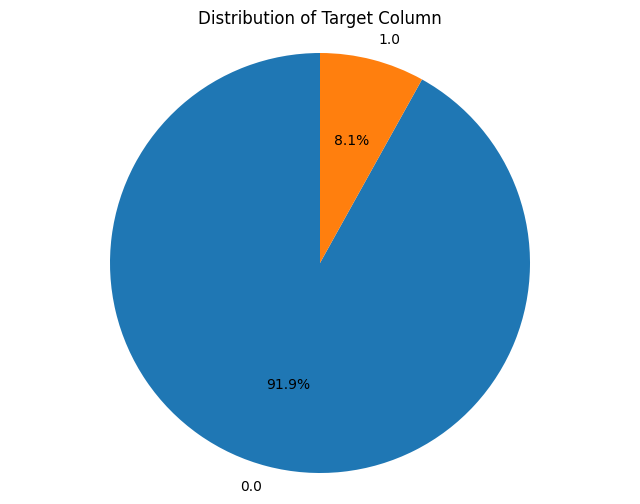

In [23]:
# Count the number of occurrences of each unique value in the 'target' column
target_counts = df_train['TARGET'].value_counts()

# Plotting
plt.figure(figsize=(8, 6))
plt.pie(target_counts, labels=target_counts.index, autopct='%1.1f%%', startangle=90)
plt.title('Distribution of Target Column')
plt.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.
plt.show()

In [24]:
#df_result = df_result.dropna()

# To verify that NaNs have been dropped, you can check the number of NaNs in the 'target' column:
print(df_train['TARGET'].isna().sum())

0


In [25]:
df_train=df_train.dropna()

In [26]:
df_predict_cleaned = df_predict.dropna(subset=df_predict.columns.difference(['TARGET']))

In [27]:
df_predict_cleaned.isna().sum() 

TARGET                                                                   12592
CODE_GENDER                                                                  0
FLAG_OWN_CAR                                                                 0
FLAG_OWN_REALTY                                                              0
CNT_CHILDREN                                                                 0
AMT_INCOME_TOTAL                                                             0
AMT_CREDIT                                                                   0
AMT_ANNUITY                                                                  0
AMT_GOODS_PRICE                                                              0
REGION_POPULATION_RELATIVE                                                   0
DAYS_BIRTH                                                                   0
DAYS_EMPLOYED                                                                0
DAYS_REGISTRATION                                   

In [28]:
df_train.shape[0]

79060

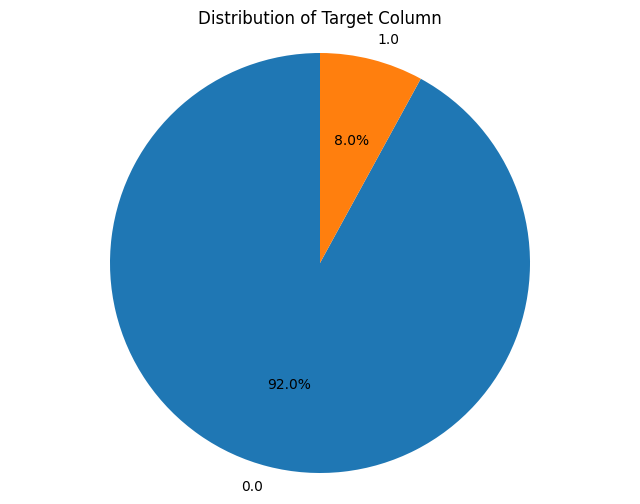

In [29]:
target_counts = df_train['TARGET'].value_counts()

# Plotting
plt.figure(figsize=(8, 6))
plt.pie(target_counts, labels=target_counts.index, autopct='%1.1f%%', startangle=90)
plt.title('Distribution of Target Column')
plt.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.
plt.show()



In [30]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
Index: 79060 entries, 5 to 307510
Columns: 551 entries, TARGET to INSTAL_COUNT
dtypes: bool(133), float64(377), int64(41)
memory usage: 262.8 MB


# Over Sampling

In [31]:
X = df_train.drop('TARGET', axis=1)  # Assuming 'target' is the column name
y = df_train['TARGET']  # Corrected assignment

# Initialize SMOTE
smote = SMOTE(sampling_strategy='auto', random_state=42)

# Apply SMOTE to generate synthetic samples
X_resampled_over, y_resampled_over = smote.fit_resample(X, y)

# Create a new DataFrame with resampled data
df_resampled_over= X_resampled_over.copy()
df_resampled_over['TARGET'] = y_resampled_over

In [26]:
len(df_resampled_over['TARGET'])

145526

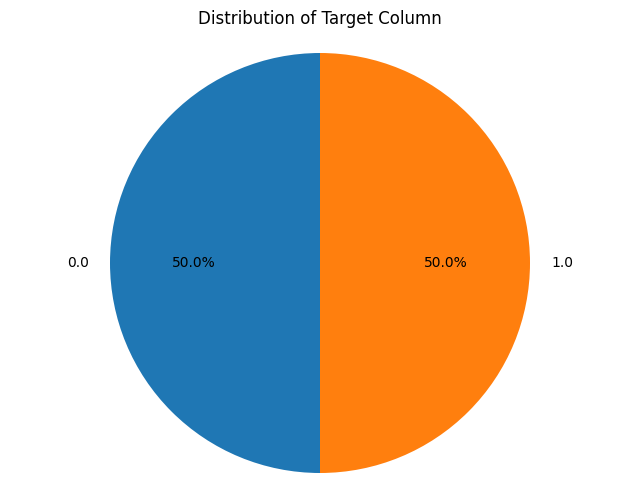

In [27]:
target_counts = df_resampled_over['TARGET'].value_counts()

# Plotting
plt.figure(figsize=(8, 6))
plt.pie(target_counts, labels=target_counts.index, autopct='%1.1f%%', startangle=90)
plt.title('Distribution of Target Column')
plt.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.
plt.show()

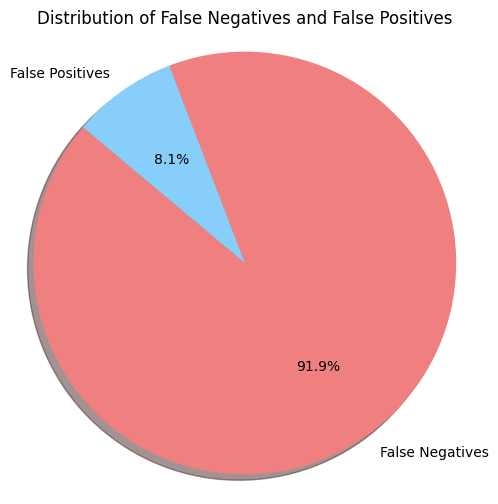

In [28]:
# Compute false negatives
false_negatives = ((df_train['TARGET'] == 0) & (df_resampled_over['TARGET'] == 1)).sum()

# Compute false positives
false_positives = ((df_train['TARGET'] == 1) & (df_resampled_over['TARGET'] == 0)).sum()

# Check if both false negatives and false positives are zero
if false_negatives == 0 and false_positives == 0:
    print("No false negatives or false positives found.")
else:
    # Create a pie chart only if there are values for false negatives or false positives
    labels = ['False Negatives', 'False Positives']
    sizes = [false_negatives, false_positives]
    colors = ['lightcoral', 'lightskyblue']

    plt.figure(figsize=(6, 6))
    plt.pie(sizes, labels=labels, colors=colors, autopct='%1.1f%%', shadow=True, startangle=140)
    plt.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.
    plt.title('Distribution of False Negatives and False Positives')
    plt.show()

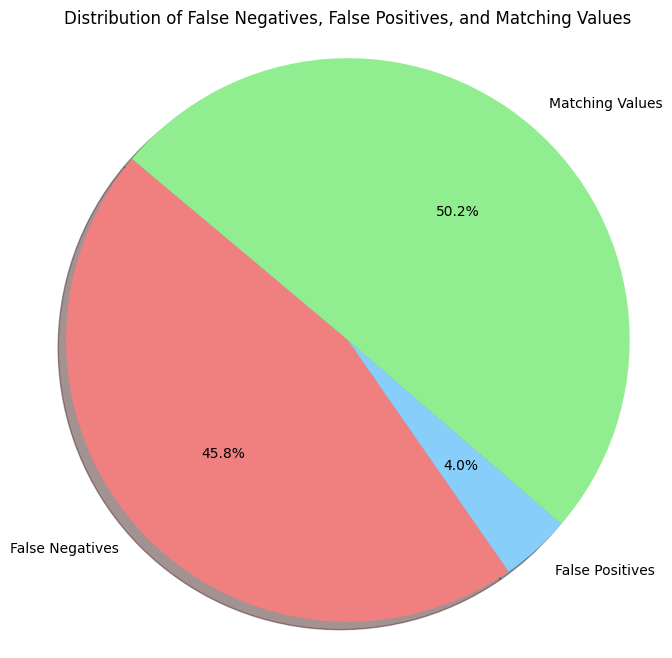

In [29]:

# Compute false negatives
false_negatives = ((df_train['TARGET'] == 0) & (df_resampled_over['TARGET'] == 1)).sum()

# Compute false positives
false_positives = ((df_train['TARGET'] == 1) & (df_resampled_over['TARGET'] == 0)).sum()

# Matching values
matching_values = ((df_train['TARGET'] == 1) & (df_resampled_over['TARGET'] == 1) | 
                   (df_train['TARGET'] == 0) & (df_resampled_over['TARGET'] == 0)).sum()

# Check if both false negatives and false positives are zero
if false_negatives == 0 and false_positives == 0:
    print("No false negatives or false positives found.")
else:
    # Create a pie chart only if there are values for false negatives or false positives
    labels = ['False Negatives', 'False Positives', 'Matching Values']
    sizes = [false_negatives, false_positives, matching_values]
    colors = ['lightcoral', 'lightskyblue', 'lightgreen']

    plt.figure(figsize=(8, 8))
    plt.pie(sizes, labels=labels, colors=colors, autopct='%1.1f%%', shadow=True, startangle=140)
    plt.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.
    plt.title('Distribution of False Negatives, False Positives, and Matching Values')
    plt.show()

# Under Sampling

In [30]:
X = df_train.drop('TARGET', axis=1)
y = df_train['TARGET']

# Initialize RandomUnderSampler
under_sampler = RandomUnderSampler(sampling_strategy='auto', random_state=42)

# Apply undersampling to generate a balanced dataset
X_resampled_under, y_resampled_under = under_sampler.fit_resample(X, y)

# Create a new DataFrame with the undersampled data
df_undersampled = X_resampled_under.copy()
df_undersampled['TARGET'] = y_resampled_under

In [31]:
len(df_undersampled['TARGET'])

12594

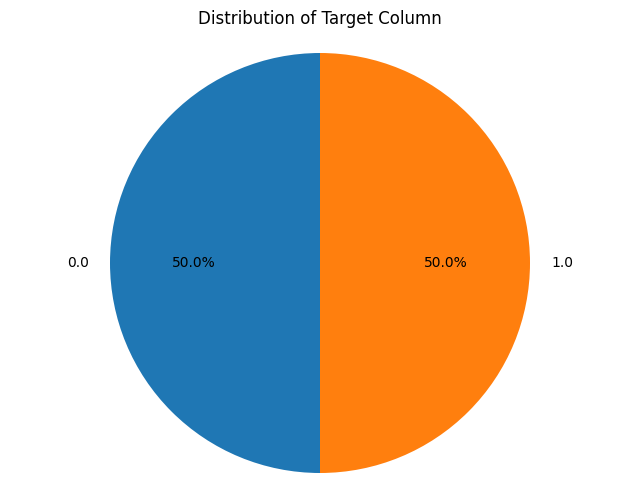

In [32]:
target_counts = df_undersampled['TARGET'].value_counts()

# Plotting
plt.figure(figsize=(8, 6))
plt.pie(target_counts, labels=target_counts.index, autopct='%1.1f%%', startangle=90)
plt.title('Distribution of Target Column')
plt.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.
plt.show()

In [33]:
# Compute false negatives
false_negatives = ((df_train['TARGET'] == 0) & (df_undersampled['TARGET'] == 1)).sum()

# Compute false positives
false_positives = ((df_train['TARGET'] == 1) & (df_undersampled['TARGET'] == 0)).sum()

# Check if both false negatives and false positives are zero
if false_negatives == 0 and false_positives == 0:
    print("No false negatives or false positives found.")
else:
    # Create a pie chart only if there are values for false negatives or false positives
    labels = ['False Negatives', 'False Positives']
    sizes = [false_negatives, false_positives]
    colors = ['lightcoral', 'lightskyblue']

    plt.figure(figsize=(6, 6))
    plt.pie(sizes, labels=labels, colors=colors, autopct='%1.1f%%', shadow=True, startangle=140)
    plt.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.
    plt.title('Distribution of False Negatives and False Positives')
    plt.show()

No false negatives or false positives found.


In [34]:

# Compute false negatives
false_negatives = ((df_train['TARGET'] == 0) & (df_undersampled['TARGET'] == 1)).sum()

# Compute false positives
false_positives = ((df_train['TARGET'] == 1) & (df_undersampled['TARGET'] == 0)).sum()

# Matching values
matching_values = ((df_train['TARGET'] == 1) & (df_undersampled['TARGET'] == 1) | 
                   (df_train['TARGET'] == 0) & (df_undersampled['TARGET'] == 0)).sum()

# Check if both false negatives and false positives are zero
if false_negatives == 0 and false_positives == 0:
    print("No false negatives or false positives found.")
else:
    # Create a pie chart only if there are values for false negatives or false positives
    labels = ['False Negatives', 'False Positives', 'Matching Values']
    sizes = [false_negatives, false_positives, matching_values]
    colors = ['lightcoral', 'lightskyblue', 'lightgreen']

    plt.figure(figsize=(8, 8))
    plt.pie(sizes, labels=labels, colors=colors, autopct='%1.1f%%', shadow=True, startangle=140)
    plt.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.
    plt.title('Distribution of False Negatives, False Positives, and Matching Values')
    plt.show()

No false negatives or false positives found.


# Under Sampled avec pipeline

In [33]:
mlflow.set_tracking_uri("mlruns")  # Set your MLflow tracking URI
mlflow.set_experiment("Classification avec Pipeline_3")  # Set your experiment name

Traceback (most recent call last):
  File "c:\Users\Dell\AppData\Local\Programs\Python\Python311\Lib\site-packages\mlflow\store\tracking\file_store.py", line 302, in search_experiments
    exp = self._get_experiment(exp_id, view_type)
          ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\Dell\AppData\Local\Programs\Python\Python311\Lib\site-packages\mlflow\store\tracking\file_store.py", line 395, in _get_experiment
    meta = FileStore._read_yaml(experiment_dir, FileStore.META_DATA_FILE_NAME)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\Dell\AppData\Local\Programs\Python\Python311\Lib\site-packages\mlflow\store\tracking\file_store.py", line 1303, in _read_yaml
    return _read_helper(root, file_name, attempts_remaining=retries)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\Dell\AppData\Local\Programs\Python\Python311\Lib\site-packages\mlflow\store\tracking\file_store.py", line 1296, 

<Experiment: artifact_location='file:///c:/Users/Dell/Projets/mlruns/505292527427982096', creation_time=1705844224473, experiment_id='505292527427982096', last_update_time=1705902489944, lifecycle_stage='active', name='Classification avec Pipeline_3', tags={}>

### Classifieur Dummy

In [37]:
# Define the pipeline with Imbalanced-Learn's Pipeline
us = RandomUnderSampler(random_state=42)
mms = MinMaxScaler()
model = DummyClassifier()  # Dummy Classifier

# Use ImbPipeline instead of make_pipeline
pipeline = ImbPipeline([
    ('randomundersampler', us),  # Move RandomUnderSampler to the beginning
    ('minmaxscaler', mms),
    ('dummyclassifier', model)  # Change the step name to 'dummyclassifier'
])

param_grid = {
    'dummyclassifier__strategy': ['most_frequent', 'stratified', 'uniform']
}


def business_score(y_true, y_pred):
    TN, FP, FN, TP = confusion_matrix(y_true, y_pred).ravel()
    score = 10 * FN + FP
    return -score

business_score = make_scorer(business_score, greater_is_better=True)

scoring = {'business_score': business_score, 'auc': 'roc_auc', 'f1': 'f1'}
grid_search = GridSearchCV(estimator=pipeline, param_grid=param_grid, cv=5, scoring=scoring, refit='business_score')

# Start the MLflow run with a specific run name
mlflow.start_run(run_name="Dummy_classifier_Undersampled")

# Record the start time
start_time = time.time()

grid_search.fit(X, y)

# Record the end time
end_time = time.time()

execution_time = end_time - start_time
   
best_params = grid_search.best_params_
best_score = grid_search.best_score_

mlflow.log_param("best_params", best_params)
mlflow.log_metric("best_score", best_score)
mlflow.log_metric("f1_score", grid_search.cv_results_['mean_test_f1'][grid_search.best_index_])
mlflow.log_metric("auc_score", grid_search.cv_results_['mean_test_auc'][grid_search.best_index_])
mlflow.log_metric("execution_time", execution_time)

# Save the model
mlflow.sklearn.log_model(grid_search.best_estimator_, "model")

# End the MLflow run
mlflow.end_run()



2024/01/21 14:37:04 WARNING mlflow.utils.git_utils: Failed to import Git (the Git executable is probably not on your PATH), so Git SHA is not available. Error: Failed to initialize: Bad git executable.
The git executable must be specified in one of the following ways:
    - be included in your $PATH
    - be set via $GIT_PYTHON_GIT_EXECUTABLE
    - explicitly set via git.refresh()

All git commands will error until this is rectified.

This initial warning can be silenced or aggravated in the future by setting the
$GIT_PYTHON_REFRESH environment variable. Use one of the following values:
    - quiet|q|silence|s|none|n|0: for no warning or exception
    - warn|w|warning|1: for a printed warning
    - error|e|raise|r|2: for a raised exception

Example:
    export GIT_PYTHON_REFRESH=quiet



### Classifieur logistique

In [38]:
# Define the pipeline with Imbalanced-Learn's Pipeline
us = RandomUnderSampler(random_state=42)
mms = MinMaxScaler()
model = LogisticRegression(max_iter=10000)  # Note the change in solver

# Use ImbPipeline instead of make_pipeline
pipeline = ImbPipeline([
    ('randomundersampler', us),
    ('minmaxscaler', mms),
    ('logisticregression', model)  # Correct the step name to 'logisticregression'
])

param_grid = {
    'logisticregression__C': [0.001, 0.01, 0.1, 1, 10, 100]
}

def business_score(y_true, y_pred):
    TN, FP, FN, TP = confusion_matrix(y_true, y_pred).ravel()
    score = 10 * FN + FP
    return -score

business_score = make_scorer(business_score, greater_is_better=True)

scoring = {'business_score': business_score, 'auc': 'roc_auc', 'f1': 'f1'}
grid_search = GridSearchCV(estimator=pipeline, param_grid=param_grid, cv=5, scoring=scoring, refit='business_score')

# Start the MLflow run with a specific run name
mlflow.start_run(run_name="Logistic_Classifier_Undersampled")

# Record the start time
start_time = time.time()

grid_search.fit(X, y)

# Record the end time
end_time = time.time()

execution_time = end_time - start_time
   
best_params = grid_search.best_params_
best_score = grid_search.best_score_

mlflow.log_param("best_params", best_params)
mlflow.log_metric("best_score", best_score)
mlflow.log_metric("f1_score", grid_search.cv_results_['mean_test_f1'][grid_search.best_index_])
mlflow.log_metric("auc_score", grid_search.cv_results_['mean_test_auc'][grid_search.best_index_])
mlflow.log_metric("execution_time", execution_time)

# Save the model
mlflow.sklearn.log_model(grid_search.best_estimator_, "model")

# End the MLflow run
mlflow.end_run()

c:\Users\Dell\AppData\Local\Programs\Python\Python311\Lib\site-packages\_distutils_hack\__init__.py:18: UserWarning: Distutils was imported before Setuptools, but importing Setuptools also replaces the `distutils` module in `sys.modules`. This may lead to undesirable behaviors or errors. To avoid these issues, avoid using distutils directly, ensure that setuptools is installed in the traditional way (e.g. not an editable install), and/or make sure that setuptools is always imported before distutils.
  warnings.warn(
c:\Users\Dell\AppData\Local\Programs\Python\Python311\Lib\site-packages\_distutils_hack\__init__.py:33: UserWarning: Setuptools is replacing distutils.
  warnings.warn("Setuptools is replacing distutils.")


### Random Forest Classifier

In [39]:
# Define the pipeline with Imbalanced-Learn's Pipeline
us = RandomUnderSampler(random_state=42)
mms = MinMaxScaler()
model = RandomForestClassifier(n_estimators=100, random_state=42)  # Random Forest Classifier

# Use ImbPipeline instead of make_pipeline
pipeline = ImbPipeline([
    ('randomundersampler', us),  # Move RandomUnderSampler to the beginning
    ('minmaxscaler', mms),
    ('randomforestclassifier', model)  # Change the step name to 'dummyclassifier'
])

param_grid = {
    'randomforestclassifier__n_estimators': [50, 100, 150],
    'randomforestclassifier__max_depth': [None, 10, 20, 30]
}


def business_score(y_true, y_pred):
    TN, FP, FN, TP = confusion_matrix(y_true, y_pred).ravel()
    score = 10 * FN + FP
    return -score

business_score = make_scorer(business_score, greater_is_better=True)

scoring = {'business_score': business_score, 'auc': 'roc_auc', 'f1': 'f1'}
grid_search = GridSearchCV(estimator=pipeline, param_grid=param_grid, cv=5, scoring=scoring, refit='business_score')

# Start the MLflow run with a specific run name
mlflow.start_run(run_name="Random_Forest_classifier_Undersampled")

# Record the start time
start_time = time.time()

grid_search.fit(X, y)

# Record the end time
end_time = time.time()

execution_time = end_time - start_time
   
best_params = grid_search.best_params_
best_score = grid_search.best_score_

mlflow.log_param("best_params", best_params)
mlflow.log_metric("best_score", best_score)
mlflow.log_metric("f1_score", grid_search.cv_results_['mean_test_f1'][grid_search.best_index_])
mlflow.log_metric("auc_score", grid_search.cv_results_['mean_test_auc'][grid_search.best_index_])
mlflow.log_metric("execution_time", execution_time)

# Save the model
mlflow.sklearn.log_model(grid_search.best_estimator_, "model")

# End the MLflow run
mlflow.end_run()

c:\Users\Dell\AppData\Local\Programs\Python\Python311\Lib\site-packages\_distutils_hack\__init__.py:18: UserWarning: Distutils was imported before Setuptools, but importing Setuptools also replaces the `distutils` module in `sys.modules`. This may lead to undesirable behaviors or errors. To avoid these issues, avoid using distutils directly, ensure that setuptools is installed in the traditional way (e.g. not an editable install), and/or make sure that setuptools is always imported before distutils.
  warnings.warn(
c:\Users\Dell\AppData\Local\Programs\Python\Python311\Lib\site-packages\_distutils_hack\__init__.py:33: UserWarning: Setuptools is replacing distutils.
  warnings.warn("Setuptools is replacing distutils.")


### XG Boost Classifier

In [40]:
# Define the pipeline with Imbalanced-Learn's Pipeline
us = RandomUnderSampler(random_state=42)
mms = MinMaxScaler()
model = XGBClassifier(verbosity=0, random_state=42)  # XGBoost Classifier

# Use ImbPipeline instead of make_pipeline
pipeline = ImbPipeline([
    ('randomundersampler', us),  # Move RandomUnderSampler to the beginning
    ('minmaxscaler', mms),
    ('xgbclassifier', model)  # Change the step name to 'dummyclassifier'
])

param_grid = {
    'xgbclassifier__learning_rate': [0.1, 0.01, 0.001],
    'xgbclassifier__max_depth': [3, 5, 7],
    'xgbclassifier__n_estimators': [50, 100, 150]
}

def business_score(y_true, y_pred):
    TN, FP, FN, TP = confusion_matrix(y_true, y_pred).ravel()
    score = 10 * FN + FP
    return -score

business_score = make_scorer(business_score, greater_is_better=True)

scoring = {'business_score': business_score, 'auc': 'roc_auc', 'f1': 'f1'}
grid_search = GridSearchCV(estimator=pipeline, param_grid=param_grid, cv=5, scoring=scoring, refit='business_score')

# Start the MLflow run with a specific run name
mlflow.start_run(run_name="XGB_Classifier_Undersampled")

# Record the start time
start_time = time.time()

grid_search.fit(X, y)

# Record the end time
end_time = time.time()

execution_time = end_time - start_time
   
best_params = grid_search.best_params_
best_score = grid_search.best_score_

mlflow.log_param("best_params", best_params)
mlflow.log_metric("best_score", best_score)
mlflow.log_metric("f1_score", grid_search.cv_results_['mean_test_f1'][grid_search.best_index_])
mlflow.log_metric("auc_score", grid_search.cv_results_['mean_test_auc'][grid_search.best_index_])
mlflow.log_metric("execution_time", execution_time)

# Save the model
mlflow.sklearn.log_model(grid_search.best_estimator_, "model")

# End the MLflow run
mlflow.end_run()

c:\Users\Dell\AppData\Local\Programs\Python\Python311\Lib\site-packages\_distutils_hack\__init__.py:18: UserWarning: Distutils was imported before Setuptools, but importing Setuptools also replaces the `distutils` module in `sys.modules`. This may lead to undesirable behaviors or errors. To avoid these issues, avoid using distutils directly, ensure that setuptools is installed in the traditional way (e.g. not an editable install), and/or make sure that setuptools is always imported before distutils.
  warnings.warn(
c:\Users\Dell\AppData\Local\Programs\Python\Python311\Lib\site-packages\_distutils_hack\__init__.py:33: UserWarning: Setuptools is replacing distutils.
  warnings.warn("Setuptools is replacing distutils.")


### KNN Classifier

In [41]:
# Define the pipeline with Imbalanced-Learn's Pipeline
us = RandomUnderSampler(random_state=42)
mms = MinMaxScaler()
model = KNeighborsClassifier()  # KNN Classifier

# Use ImbPipeline instead of make_pipeline
pipeline = ImbPipeline([
    ('randomundersampler', us),  # Move RandomUnderSampler to the beginning
    ('minmaxscaler', mms),
    ('kneighborsclassifier', model)  # Change the step name to 'dummyclassifier'
])

param_grid = {
    'kneighborsclassifier__n_neighbors': [3, 5, 7],
    'kneighborsclassifier__weights': ['uniform', 'distance']
}


def business_score(y_true, y_pred):
    TN, FP, FN, TP = confusion_matrix(y_true, y_pred).ravel()
    score = 10 * FN + FP
    return -score

business_score = make_scorer(business_score, greater_is_better=True)

scoring = {'business_score': business_score, 'auc': 'roc_auc', 'f1': 'f1'}
grid_search = GridSearchCV(estimator=pipeline, param_grid=param_grid, cv=5, scoring=scoring, refit='business_score')

# Start the MLflow run with a specific run name
mlflow.start_run(run_name="KNN_Classifier_Undersampled")

# Record the start time
start_time = time.time()

grid_search.fit(X, y)

# Record the end time
end_time = time.time()

execution_time = end_time - start_time
   
best_params = grid_search.best_params_
best_score = grid_search.best_score_

mlflow.log_param("best_params", best_params)
mlflow.log_metric("best_score", best_score)
mlflow.log_metric("f1_score", grid_search.cv_results_['mean_test_f1'][grid_search.best_index_])
mlflow.log_metric("auc_score", grid_search.cv_results_['mean_test_auc'][grid_search.best_index_])
mlflow.log_metric("execution_time", execution_time)

# Save the model
mlflow.sklearn.log_model(grid_search.best_estimator_, "model")

# End the MLflow run
mlflow.end_run()


c:\Users\Dell\AppData\Local\Programs\Python\Python311\Lib\site-packages\_distutils_hack\__init__.py:18: UserWarning: Distutils was imported before Setuptools, but importing Setuptools also replaces the `distutils` module in `sys.modules`. This may lead to undesirable behaviors or errors. To avoid these issues, avoid using distutils directly, ensure that setuptools is installed in the traditional way (e.g. not an editable install), and/or make sure that setuptools is always imported before distutils.
  warnings.warn(
c:\Users\Dell\AppData\Local\Programs\Python\Python311\Lib\site-packages\_distutils_hack\__init__.py:33: UserWarning: Setuptools is replacing distutils.
  warnings.warn("Setuptools is replacing distutils.")


# Over Sampled avec pipeline

### Classifieur Dummy

In [59]:
# Define the pipeline with Imbalanced-Learn's Pipeline
os = RandomOverSampler(random_state=42)  # Change to RandomOverSampler
mms = MinMaxScaler()
model = DummyClassifier()  # Dummy Classifier

# Use ImbPipeline instead of make_pipeline
pipeline = ImbPipeline([
    ('randomoversampler', os ),  # Move RandomUnderSampler to the beginning
    ('minmaxscaler', mms),
    ('dummyclassifier', model)  # Change the step name to 'dummyclassifier'
])

param_grid = {
    'dummyclassifier__strategy': ['most_frequent', 'stratified', 'uniform']
}

def business_score(y_true, y_pred):
    TN, FP, FN, TP = confusion_matrix(y_true, y_pred).ravel()
    score = 10 * FN + FP
    return -score

business_score = make_scorer(business_score, greater_is_better=True)

scoring = {'business_score': business_score, 'auc': 'roc_auc', 'f1': 'f1'}
grid_search = GridSearchCV(estimator=pipeline, param_grid=param_grid, cv=5, scoring=scoring, refit='business_score')

# Start the MLflow run with a specific run name
mlflow.start_run(run_name="Dummy_classifier_Oversampled")  # Change the run name

# Record the start time
start_time = time.time()

grid_search.fit(X, y)

# Record the end time
end_time = time.time()

execution_time = end_time - start_time
   
best_params = grid_search.best_params_
best_score = grid_search.best_score_

mlflow.log_param("best_params", best_params)
mlflow.log_metric("best_score", best_score)
mlflow.log_metric("f1_score", grid_search.cv_results_['mean_test_f1'][grid_search.best_index_])
mlflow.log_metric("auc_score", grid_search.cv_results_['mean_test_auc'][grid_search.best_index_])
mlflow.log_metric("execution_time", execution_time)

# Save the model
mlflow.sklearn.log_model(grid_search.best_estimator_, "model")

# End the MLflow run
mlflow.end_run()

c:\Users\Dell\AppData\Local\Programs\Python\Python311\Lib\site-packages\_distutils_hack\__init__.py:18: UserWarning: Distutils was imported before Setuptools, but importing Setuptools also replaces the `distutils` module in `sys.modules`. This may lead to undesirable behaviors or errors. To avoid these issues, avoid using distutils directly, ensure that setuptools is installed in the traditional way (e.g. not an editable install), and/or make sure that setuptools is always imported before distutils.
  warnings.warn(
c:\Users\Dell\AppData\Local\Programs\Python\Python311\Lib\site-packages\_distutils_hack\__init__.py:33: UserWarning: Setuptools is replacing distutils.
  warnings.warn("Setuptools is replacing distutils.")


### Classifieur logistique

In [60]:
# Define the pipeline with Imbalanced-Learn's Pipeline
os = RandomOverSampler(random_state=42)  # Change to RandomOverSampler
mms = MinMaxScaler()
model = LogisticRegression(max_iter=10000)  # Note the change in solver

# Use ImbPipeline instead of make_pipeline
pipeline = ImbPipeline([
    ('randomoversampler', os ),  # Move RandomUnderSampler to the beginning
    ('minmaxscaler', mms),
    ('logisticregression', model)  # Change the step name to 'dummyclassifier'
])

param_grid = {
    'logisticregression__C': [0.001, 0.01, 0.1, 1, 10, 100]
}

def business_score(y_true, y_pred):
    TN, FP, FN, TP = confusion_matrix(y_true, y_pred).ravel()
    score = 10 * FN + FP
    return -score

business_score = make_scorer(business_score, greater_is_better=True)

scoring = {'business_score': business_score, 'auc': 'roc_auc', 'f1': 'f1'}
grid_search = GridSearchCV(estimator=pipeline, param_grid=param_grid, cv=5, scoring=scoring, refit='business_score')

# Start the MLflow run with a specific run name
mlflow.start_run(run_name="Logistic_Classifier_Oversampled")  # Change the run name

# Record the start time
start_time = time.time()

grid_search.fit(X, y)

# Record the end time
end_time = time.time()

execution_time = end_time - start_time
   
best_params = grid_search.best_params_
best_score = grid_search.best_score_

mlflow.log_param("best_params", best_params)
mlflow.log_metric("best_score", best_score)
mlflow.log_metric("f1_score", grid_search.cv_results_['mean_test_f1'][grid_search.best_index_])
mlflow.log_metric("auc_score", grid_search.cv_results_['mean_test_auc'][grid_search.best_index_])
mlflow.log_metric("execution_time", execution_time)

# Save the model
mlflow.sklearn.log_model(grid_search.best_estimator_, "model")

# End the MLflow run
mlflow.end_run()

c:\Users\Dell\AppData\Local\Programs\Python\Python311\Lib\site-packages\_distutils_hack\__init__.py:18: UserWarning: Distutils was imported before Setuptools, but importing Setuptools also replaces the `distutils` module in `sys.modules`. This may lead to undesirable behaviors or errors. To avoid these issues, avoid using distutils directly, ensure that setuptools is installed in the traditional way (e.g. not an editable install), and/or make sure that setuptools is always imported before distutils.
  warnings.warn(
c:\Users\Dell\AppData\Local\Programs\Python\Python311\Lib\site-packages\_distutils_hack\__init__.py:33: UserWarning: Setuptools is replacing distutils.
  warnings.warn("Setuptools is replacing distutils.")


### Random Forest Classifier

In [61]:
# Define the pipeline with Imbalanced-Learn's Pipeline
os = RandomOverSampler(random_state=42)  # Change to RandomOverSampler
mms = MinMaxScaler()
model = RandomForestClassifier(n_estimators=100, random_state=42)  # Random Forest Classifier

# Use ImbPipeline instead of make_pipeline
pipeline = ImbPipeline([
    ('randomoversampler', os ), # Move RandomUnderSampler to the beginning
    ('minmaxscaler', mms),
    ('randomforestclassifier', model)  # Change the step name to 'dummyclassifier'
])

param_grid = {
    'randomforestclassifier__n_estimators': [50, 100, 150],
    'randomforestclassifier__max_depth': [None, 10, 20, 30]
}

def business_score(y_true, y_pred):
    TN, FP, FN, TP = confusion_matrix(y_true, y_pred).ravel()
    score = 10 * FN + FP
    return -score

business_score = make_scorer(business_score, greater_is_better=True)

scoring = {'business_score': business_score, 'auc': 'roc_auc', 'f1': 'f1'}
grid_search = GridSearchCV(estimator=pipeline, param_grid=param_grid, cv=5, scoring=scoring, refit='business_score')

# Start the MLflow run with a specific run name
mlflow.start_run(run_name="Random_Forest_classifier_Oversampled")  # Change the run name

# Record the start time
start_time = time.time()

grid_search.fit(X, y)

# Record the end time
end_time = time.time()

execution_time = end_time - start_time
   
best_params = grid_search.best_params_
best_score = grid_search.best_score_

mlflow.log_param("best_params", best_params)
mlflow.log_metric("best_score", best_score)
mlflow.log_metric("f1_score", grid_search.cv_results_['mean_test_f1'][grid_search.best_index_])
mlflow.log_metric("auc_score", grid_search.cv_results_['mean_test_auc'][grid_search.best_index_])
mlflow.log_metric("execution_time", execution_time)

# Save the model
mlflow.sklearn.log_model(grid_search.best_estimator_, "model")

# End the MLflow run
mlflow.end_run()

c:\Users\Dell\AppData\Local\Programs\Python\Python311\Lib\site-packages\_distutils_hack\__init__.py:18: UserWarning: Distutils was imported before Setuptools, but importing Setuptools also replaces the `distutils` module in `sys.modules`. This may lead to undesirable behaviors or errors. To avoid these issues, avoid using distutils directly, ensure that setuptools is installed in the traditional way (e.g. not an editable install), and/or make sure that setuptools is always imported before distutils.
  warnings.warn(
c:\Users\Dell\AppData\Local\Programs\Python\Python311\Lib\site-packages\_distutils_hack\__init__.py:33: UserWarning: Setuptools is replacing distutils.
  warnings.warn("Setuptools is replacing distutils.")


### XG Boost Classifier

In [34]:
# Define the pipeline with Imbalanced-Learn's Pipeline
os = RandomOverSampler(random_state=42)  # Change to RandomOverSampler
mms = MinMaxScaler()
model = XGBClassifier(verbosity=0, random_state=42)  # XGBoost Classifier

# Use ImbPipeline instead of make_pipeline
pipeline = ImbPipeline([
    ('randomoversampler', os ),  # Move RandomUnderSampler to the beginning
    ('minmaxscaler', mms),
    ('xgbclassifier', model)  # Change the step name to 'dummyclassifier'
])

param_grid = {
    'xgbclassifier__learning_rate': [0.1, 0.01, 0.001],
    'xgbclassifier__max_depth': [3, 5, 7],
    'xgbclassifier__n_estimators': [50, 100, 150]
}

def business_score(y_true, y_pred):
    TN, FP, FN, TP = confusion_matrix(y_true, y_pred).ravel()
    score = 10 * FN + FP
    return -score

business_score = make_scorer(business_score, greater_is_better=True)

scoring = {'business_score': business_score, 'auc': 'roc_auc', 'f1': 'f1'}
grid_search = GridSearchCV(estimator=pipeline, param_grid=param_grid, cv=5, scoring=scoring, refit='business_score')

# Start the MLflow run with a specific run name
mlflow.start_run(run_name="XGB_Classifier_Oversampled")  # Change the run name

# Record the start time
start_time = time.time()

grid_search.fit(X, y)

# Record the end time
end_time = time.time()

execution_time = end_time - start_time
   
best_params = grid_search.best_params_
best_score = grid_search.best_score_

mlflow.log_param("best_params", best_params)
mlflow.log_metric("best_score", best_score)
mlflow.log_metric("f1_score", grid_search.cv_results_['mean_test_f1'][grid_search.best_index_])
mlflow.log_metric("auc_score", grid_search.cv_results_['mean_test_auc'][grid_search.best_index_])
mlflow.log_metric("execution_time", execution_time)

# Save the model
mlflow.sklearn.log_model(grid_search.best_estimator_, "model")

# End the MLflow run
mlflow.end_run()

2024/01/22 06:48:43 WARNING mlflow.utils.git_utils: Failed to import Git (the Git executable is probably not on your PATH), so Git SHA is not available. Error: Failed to initialize: Bad git executable.
The git executable must be specified in one of the following ways:
    - be included in your $PATH
    - be set via $GIT_PYTHON_GIT_EXECUTABLE
    - explicitly set via git.refresh()

All git commands will error until this is rectified.

This initial warning can be silenced or aggravated in the future by setting the
$GIT_PYTHON_REFRESH environment variable. Use one of the following values:
    - quiet|q|silence|s|none|n|0: for no warning or exception
    - warn|w|warning|1: for a printed warning
    - error|e|raise|r|2: for a raised exception

Example:
    export GIT_PYTHON_REFRESH=quiet



### KNN Classifier

In [35]:
# Define the pipeline with Imbalanced-Learn's Pipeline
os = RandomOverSampler(random_state=42)  # Change to RandomOverSampler
mms = MinMaxScaler()
model = KNeighborsClassifier()  # KNN Classifier

# Use ImbPipeline instead of make_pipeline
pipeline = ImbPipeline([
    ('randomoversampler', os ),  # Move RandomUnderSampler to the beginning
    ('minmaxscaler', mms),
    ('kneighborsclassifier', model)  # Change the step name to 'dummyclassifier'
])

param_grid = {
    'kneighborsclassifier__n_neighbors': [3, 5, 7],
    'kneighborsclassifier__weights': ['uniform', 'distance']
}

def business_score(y_true, y_pred):
    TN, FP, FN, TP = confusion_matrix(y_true, y_pred).ravel()
    score = 10 * FN + FP
    return -score

business_score = make_scorer(business_score, greater_is_better=True)

scoring = {'business_score': business_score, 'auc': 'roc_auc', 'f1': 'f1'}
grid_search = GridSearchCV(estimator=pipeline, param_grid=param_grid, cv=5, scoring=scoring, refit='business_score')

# Start the MLflow run with a specific run name
mlflow.start_run(run_name="KNN_Classifier_Oversampled")  # Change the run name

# Record the start time
start_time = time.time()

grid_search.fit(X, y)

# Record the end time
end_time = time.time()

execution_time = end_time - start_time
   
best_params = grid_search.best_params_
best_score = grid_search.best_score_

mlflow.log_param("best_params", best_params)
mlflow.log_metric("best_score", best_score)
mlflow.log_metric("f1_score", grid_search.cv_results_['mean_test_f1'][grid_search.best_index_])
mlflow.log_metric("auc_score", grid_search.cv_results_['mean_test_auc'][grid_search.best_index_])
mlflow.log_metric("execution_time", execution_time)

# Save the model
mlflow.sklearn.log_model(grid_search.best_estimator_, "model")

# End the MLflow run
mlflow.end_run()

c:\Users\Dell\AppData\Local\Programs\Python\Python311\Lib\site-packages\_distutils_hack\__init__.py:18: UserWarning: Distutils was imported before Setuptools, but importing Setuptools also replaces the `distutils` module in `sys.modules`. This may lead to undesirable behaviors or errors. To avoid these issues, avoid using distutils directly, ensure that setuptools is installed in the traditional way (e.g. not an editable install), and/or make sure that setuptools is always imported before distutils.
  warnings.warn(
c:\Users\Dell\AppData\Local\Programs\Python\Python311\Lib\site-packages\_distutils_hack\__init__.py:33: UserWarning: Setuptools is replacing distutils.
  warnings.warn("Setuptools is replacing distutils.")


# XG Boost Sampler avec Pipeline

In [36]:
# Define the pipeline with Imbalanced-Learn's Pipeline
mms = MinMaxScaler()
model = XGBClassifier(verbosity=0, random_state=42)  # XGBoost Classifier

positive_samples = df_train['TARGET'].sum()
negative_samples = len(df_train) - positive_samples
imbalance_ratio = negative_samples / positive_samples

# Use ImbPipeline instead of make_pipeline
pipeline = ImbPipeline([
    ('minmaxscaler', mms),  # Change to XGBClassifier for sampling
    ('xgbclassifier', model)  # Change the step name to 'xgbclassifier'
])

param_grid = {
    'xgbclassifier__learning_rate': [0.1, 0.01, 0.001],
    'xgbclassifier__max_depth': [3, 5, 7],
    'xgbclassifier__n_estimators': [50, 100, 150],
    'xgbclassifier__scale_pos_weight': [imbalance_ratio],
}

def business_score(y_true, y_pred):
    TN, FP, FN, TP = confusion_matrix(y_true, y_pred).ravel()
    score = 10 * FN + FP
    return -score

business_score = make_scorer(business_score, greater_is_better=True)

scoring = {'business_score': business_score, 'auc': 'roc_auc', 'f1': 'f1'}
grid_search = GridSearchCV(estimator=pipeline, param_grid=param_grid, cv=5, scoring=scoring, refit='business_score')

# Start the MLflow run with a specific run name
mlflow.start_run(run_name="XGB_Classifier_XGB_Sampled")  # Change the run name

# Record the start time
start_time = time.time()

grid_search.fit(X, y)

# Record the end time
end_time = time.time()

execution_time = end_time - start_time
   
best_params = grid_search.best_params_
best_score = grid_search.best_score_

mlflow.log_param("best_params", best_params)
mlflow.log_metric("best_score", best_score)
mlflow.log_metric("f1_score", grid_search.cv_results_['mean_test_f1'][grid_search.best_index_])
mlflow.log_metric("auc_score", grid_search.cv_results_['mean_test_auc'][grid_search.best_index_])
mlflow.log_metric("execution_time", execution_time)

# Save the model
mlflow.sklearn.log_model(grid_search.best_estimator_, "model")

# End the MLflow run
mlflow.end_run()

c:\Users\Dell\AppData\Local\Programs\Python\Python311\Lib\site-packages\_distutils_hack\__init__.py:18: UserWarning: Distutils was imported before Setuptools, but importing Setuptools also replaces the `distutils` module in `sys.modules`. This may lead to undesirable behaviors or errors. To avoid these issues, avoid using distutils directly, ensure that setuptools is installed in the traditional way (e.g. not an editable install), and/or make sure that setuptools is always imported before distutils.
  warnings.warn(
c:\Users\Dell\AppData\Local\Programs\Python\Python311\Lib\site-packages\_distutils_hack\__init__.py:33: UserWarning: Setuptools is replacing distutils.
  warnings.warn("Setuptools is replacing distutils.")


# Undersampled Flow

In [ ]:
X_under= df_undersampled.drop('TARGET', axis=1)
y_under= df_undersampled['TARGET']

X_train_under, X_test_under, y_train_under, y_test_under= train_test_split(X_under, y_under, test_size=0.2, random_state=42)

In [50]:
mlflow.set_tracking_uri("mlruns")  # Set your MLflow tracking URI
mlflow.set_experiment("Undersampled_logistic_regression")  # Set your experiment name

Traceback (most recent call last):
  File "C:\Users\Dell\AppData\Local\Programs\Python\Python311\Lib\site-packages\mlflow\store\tracking\file_store.py", line 302, in search_experiments
    exp = self._get_experiment(exp_id, view_type)
          ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\Dell\AppData\Local\Programs\Python\Python311\Lib\site-packages\mlflow\store\tracking\file_store.py", line 395, in _get_experiment
    meta = FileStore._read_yaml(experiment_dir, FileStore.META_DATA_FILE_NAME)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\Dell\AppData\Local\Programs\Python\Python311\Lib\site-packages\mlflow\store\tracking\file_store.py", line 1303, in _read_yaml
    return _read_helper(root, file_name, attempts_remaining=retries)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\Dell\AppData\Local\Programs\Python\Python311\Lib\site-packages\mlflow\store\tracking\file_store.py", line 1296, 

<Experiment: artifact_location='file:///C:/Users/Dell/Projets/mlruns/407178898557629965', creation_time=1704720306831, experiment_id='407178898557629965', last_update_time=1704720306831, lifecycle_stage='active', name='Undersampled_logistic_regression', tags={}>

### Classifieur Dummy

In [53]:
# Create a Dummy Classifier
dummy_classifier = DummyClassifier(strategy="most_frequent")  # Predicts the most frequent class

# Train the model
start_time = time.time()
dummy_classifier.fit(X_train_under, y_train_under)
end_time = time.time()

# Predict using the trained model
y_pred_under = dummy_classifier.predict(X_test_under)

# Compute evaluation metrics
auc = roc_auc_score(y_test_under, y_pred_under)
fn_fp_metric = 10 * confusion_matrix(y_test_under, y_pred_under)[1, 0] + 1 * confusion_matrix(y_test_under, y_pred_under)[0, 1]
false_negatives = confusion_matrix(y_test_under, y_pred_under)[1, 0]

# Log the metrics using MLflow
with mlflow.start_run(run_name="DummyClassifier_Undersampled"):
    mlflow.log_params({"strategy": "most_frequent"})  # Log the strategy used by the DummyClassifier
    mlflow.log_metric("AUC", auc)
    mlflow.log_metric("fn_fp_metric", fn_fp_metric)
    mlflow.log_metric("false_negatives", false_negatives)
    mlflow.log_metric("execution_time", end_time - start_time)

# End the MLflow run
mlflow.end_run()

### Classifieur logistique

In [61]:
# Define the parameter grid for Logistic Regression
param_grid = {'C': [0.001, 0.01, 0.1, 1, 10, 100]}

# Initialize GridSearchCV
grid_search = GridSearchCV(LogisticRegression(max_iter=10000), param_grid, cv=5, scoring='roc_auc', n_jobs=-1)

# Start MLflow run for grid search
grid_search.fit(X_train_under, y_train_under)
best_params_under_log_reg = grid_search.best_params_

# Extract the best C value
best_C = best_params_under_log_reg['C']

# Initialize Logistic Regression with the best C value
logistic_regressor = LogisticRegression(C=best_C, max_iter=10000)

# Train the model
start_time = time.time()
logistic_regressor.fit(X_train_under, y_train_under)
end_time = time.time()

# Predict using the trained model
y_pred_under = logistic_regressor.predict(X_test_under)

# Compute evaluation metrics
auc = roc_auc_score(y_test_under, y_pred_under)
fn_fp_metric = 10 * confusion_matrix(y_test_under, y_pred_under)[1, 0] + 1 * confusion_matrix(y_test_under, y_pred_under)[0, 1]
false_negatives = confusion_matrix(y_test_under, y_pred_under)[1, 0]

# Log the metrics using MLflow
with mlflow.start_run(run_name="LogisticRegression_Undersampled"):
    mlflow.log_params(grid_search.best_params_)
    mlflow.log_params({"C": best_C})
    mlflow.log_metric("AUC", auc)
    mlflow.log_metric("fn_fp_metric", fn_fp_metric)
    mlflow.log_metric("false_negatives", false_negatives)
    mlflow.log_metric("execution_time", end_time - start_time)

# End the MLflow run
mlflow.end_run()

### Classifieur XGB

In [63]:
# Define the parameter grid for XGBoost
param_grid_xgb = {
    'learning_rate': [0.01, 0.1, 0.2],
    'max_depth': [3, 4, 5],
    'n_estimators': [50, 100, 200]
}

# Initialize GridSearchCV for XGBoost
grid_search_xgb = GridSearchCV(xgb.XGBClassifier(use_label_encoder=False), param_grid_xgb, cv=5, scoring='roc_auc', n_jobs=-1)

# Execute Grid Search
grid_search_xgb.fit(X_train_under, y_train_under)
best_params_xgb = grid_search_xgb.best_params_

# Extract the best parameters
best_learning_rate = best_params_xgb['learning_rate']
best_max_depth = best_params_xgb['max_depth']
best_n_estimators = best_params_xgb['n_estimators']

# Initialize XGBoost with best parameters
xgb_classifier = xgb.XGBClassifier(learning_rate=best_learning_rate, max_depth=best_max_depth, n_estimators=best_n_estimators, use_label_encoder=False)

# Train the model
start_time = time.time()
xgb_classifier.fit(X_train_under, y_train_under)
end_time = time.time()

# Predict using the trained model
y_pred_under_xgb = xgb_classifier.predict(X_test_under)

# Compute evaluation metrics
auc_xgb = roc_auc_score(y_test_under, y_pred_under_xgb)
fn_fp_metric_xgb = 10 * confusion_matrix(y_test_under, y_pred_under_xgb)[1, 0] + 1 * confusion_matrix(y_test_under, y_pred_under_xgb)[0, 1]
false_negatives_xgb = confusion_matrix(y_test_under, y_pred_under_xgb)[1, 0]

# Log the metrics using MLflow
with mlflow.start_run(run_name="XGBoost_Undersampled"):
    mlflow.log_params(grid_search_xgb.best_params_)
    mlflow.log_metric("AUC", auc_xgb)
    mlflow.log_metric("fn_fp_metric", fn_fp_metric_xgb)
    mlflow.log_metric("false_negatives", false_negatives_xgb)
    mlflow.log_metric("execution_time", end_time - start_time)

# End the MLflow run
mlflow.end_run()

### Classifieur Random Forest

In [64]:
# Define the parameter grid for Random Forest
param_grid_rf = {
    'n_estimators': [50, 100, 200],
    'max_depth': [None, 10, 20],
    'min_samples_split': [2, 5, 10]
}

# Initialize GridSearchCV for Random Forest
grid_search_rf = GridSearchCV(RandomForestClassifier(), param_grid_rf, cv=5, scoring='roc_auc', n_jobs=-1)

# Execute Grid Search
grid_search_rf.fit(X_train_under, y_train_under)
best_params_rf = grid_search_rf.best_params_

# Extract the best parameters
best_n_estimators_rf = best_params_rf['n_estimators']
best_max_depth_rf = best_params_rf['max_depth']
best_min_samples_split_rf = best_params_rf['min_samples_split']

# Initialize Random Forest with best parameters
rf_classifier = RandomForestClassifier(n_estimators=best_n_estimators_rf, max_depth=best_max_depth_rf, min_samples_split=best_min_samples_split_rf)

# Train the model
start_time = time.time()
rf_classifier.fit(X_train_under, y_train_under)
end_time = time.time()

# Predict using the trained model
y_pred_under_rf = rf_classifier.predict(X_test_under)

# Compute evaluation metrics
auc_rf = roc_auc_score(y_test_under, y_pred_under_rf)
fn_fp_metric_rf = 10 * confusion_matrix(y_test_under, y_pred_under_rf)[1, 0] + 1 * confusion_matrix(y_test_under, y_pred_under_rf)[0, 1]
false_negatives_rf = confusion_matrix(y_test_under, y_pred_under_rf)[1, 0]

# Log the metrics using MLflow
with mlflow.start_run(run_name="RandomForest_Undersampled"):
    mlflow.log_params(grid_search_rf.best_params_)
    mlflow.log_metric("AUC", auc_rf)
    mlflow.log_metric("fn_fp_metric", fn_fp_metric_rf)
    mlflow.log_metric("false_negatives", false_negatives_rf)
    mlflow.log_metric("execution_time", end_time - start_time)

# End the MLflow run
mlflow.end_run()

### Classifieur KNN

In [65]:
# Define the parameter grid for KNN
param_grid_knn = {
    'n_neighbors': [3, 5, 7, 9],
    'weights': ['uniform', 'distance']
}

# Initialize GridSearchCV for KNN
grid_search_knn = GridSearchCV(KNeighborsClassifier(), param_grid_knn, cv=5, scoring='roc_auc', n_jobs=-1)

# Execute Grid Search
grid_search_knn.fit(X_train_under, y_train_under)
best_params_knn = grid_search_knn.best_params_

# Extract the best parameters
best_n_neighbors = best_params_knn['n_neighbors']
best_weights = best_params_knn['weights']

# Initialize KNN with best parameters
knn_classifier = KNeighborsClassifier(n_neighbors=best_n_neighbors, weights=best_weights)

# Train the model
start_time = time.time()
knn_classifier.fit(X_train_under, y_train_under)
end_time = time.time()

# Predict using the trained model
y_pred_under_knn = knn_classifier.predict(X_test_under)

# Compute evaluation metrics
auc_knn = roc_auc_score(y_test_under, y_pred_under_knn)
fn_fp_metric_knn = 10 * confusion_matrix(y_test_under, y_pred_under_knn)[1, 0] + 1 * confusion_matrix(y_test_under, y_pred_under_knn)[0, 1]
false_negatives_knn = confusion_matrix(y_test_under, y_pred_under_knn)[1, 0]

# Log the metrics using MLflow
with mlflow.start_run(run_name="KNN_Undersampled"):
    mlflow.log_params(grid_search_knn.best_params_)
    mlflow.log_metric("AUC", auc_knn)
    mlflow.log_metric("fn_fp_metric", fn_fp_metric_knn)
    mlflow.log_metric("false_negatives", false_negatives_knn)
    mlflow.log_metric("execution_time", end_time - start_time)

# End the MLflow run
mlflow.end_run()

# Oversampled Flow

In [50]:
X_over = df_resampled_over.drop('TARGET', axis=1)
y_over = df_resampled_over['TARGET']

X_train_over, X_test_over, y_train_over, y_test_over = train_test_split(X_over, y_over, test_size=0.2, random_state=42)

In [55]:
X_train_over.shape

(116420, 551)

In [56]:
y_train_over.shape

(116420,)

### Classifieur Dummy

In [57]:
# Create a Dummy Classifier
dummy_classifier = DummyClassifier(strategy="most_frequent")  # Predicts the most frequent class

# Train the model
start_time = time.time()
dummy_classifier.fit(X_train_over, y_train_over)
end_time = time.time()

# Predict using the trained model
y_pred_over = dummy_classifier.predict(X_test_over)

# Compute evaluation metrics
auc = roc_auc_score(y_test_over, y_pred_over)
fn_fp_metric = 10 * confusion_matrix(y_test_over, y_pred_over)[1, 0] + 1 * confusion_matrix(y_test_over, y_pred_over)[0, 1]
false_negatives = confusion_matrix(y_test_over, y_pred_over)[1, 0]

# Log the metrics using MLflow
with mlflow.start_run(run_name="DummyClassifier_oversampled"):
    mlflow.log_params({"strategy": "most_frequent"})  # Log the strategy used by the DummyClassifier
    mlflow.log_metric("AUC", auc)
    mlflow.log_metric("fn_fp_metric", fn_fp_metric)
    mlflow.log_metric("false_negatives", false_negatives)
    mlflow.log_metric("execution_time", end_time - start_time)

# End the MLflow run
mlflow.end_run()

### Classifieur Logistique

In [67]:
# Define the parameter grid for Logistic Regression
param_grid = {'C': [0.001, 0.01, 0.1, 1, 10, 100]}

# Initialize GridSearchCV
grid_search = GridSearchCV(LogisticRegression(max_iter=10000), param_grid, cv=5, scoring='roc_auc', n_jobs=-1)

# Start MLflow run for grid search
grid_search.fit(X_train_over, y_train_over)
best_params_over_log_reg = grid_search.best_params_

# Extract the best C value
best_C = best_params_over_log_reg['C']

# Initialize Logistic Regression with the best C value
logistic_regressor = LogisticRegression(C=best_C, max_iter=10000)

# Train the model
start_time = time.time()
logistic_regressor.fit(X_train_over, y_train_over)
end_time = time.time()

# Predict using the trained model
y_pred_over = logistic_regressor.predict(X_test_over)

# Compute evaluation metrics
auc = roc_auc_score(y_test_over, y_pred_over)
fn_fp_metric = 10 * confusion_matrix(y_test_over, y_pred_over)[1, 0] + 1 * confusion_matrix(y_test_over, y_pred_over)[0, 1]
false_negatives = confusion_matrix(y_test_over, y_pred_over)[1, 0]

# Log the metrics using MLflow
with mlflow.start_run(run_name="LogisticRegression_oversampled"):
    mlflow.log_params({"C": best_C})
    mlflow.log_metric("AUC", auc)
    mlflow.log_metric("fn_fp_metric", fn_fp_metric)
    mlflow.log_metric("false_negatives", false_negatives)
    mlflow.log_metric("execution_time", end_time - start_time)

# End the MLflow run
mlflow.end_run()

### Classifieur XGB

In [68]:
import xgboost as xgb

# Define the parameter grid for XGBoost
param_grid_xgb = {
    'learning_rate': [0.01, 0.1, 0.2],
    'max_depth': [3, 4, 5],
    'n_estimators': [50, 100, 200]
}

# Initialize GridSearchCV for XGBoost
grid_search_xgb = GridSearchCV(xgb.XGBClassifier(use_label_encoder=False), param_grid_xgb, cv=5, scoring='roc_auc', n_jobs=-1)

# Execute Grid Search
grid_search_xgb.fit(X_train_over, y_train_over)
best_params_xgb = grid_search_xgb.best_params_

# Extract the best parameters
best_learning_rate = best_params_xgb['learning_rate']
best_max_depth = best_params_xgb['max_depth']
best_n_estimators = best_params_xgb['n_estimators']

# Initialize XGBoost with best parameters
xgb_classifier = xgb.XGBClassifier(learning_rate=best_learning_rate, max_depth=best_max_depth, n_estimators=best_n_estimators, use_label_encoder=False)

# Train the model
start_time = time.time()
xgb_classifier.fit(X_train_over, y_train_over)
end_time = time.time()

# Predict using the trained model
y_pred_over_xgb = xgb_classifier.predict(X_test_over)

# Compute evaluation metrics
auc_xgb = roc_auc_score(y_test_over, y_pred_over_xgb)
fn_fp_metric_xgb = 10 * confusion_matrix(y_test_over, y_pred_over_xgb)[1, 0] + 1 * confusion_matrix(y_test_over, y_pred_over_xgb)[0, 1]
false_negatives_xgb = confusion_matrix(y_test_over, y_pred_over_xgb)[1, 0]

# Log the metrics using MLflow
with mlflow.start_run(run_name="XGBoost_oversampled"):
    mlflow.log_params(grid_search_xgb.best_params_)
    mlflow.log_metric("AUC", auc_xgb)
    mlflow.log_metric("fn_fp_metric", fn_fp_metric_xgb)
    mlflow.log_metric("false_negatives", false_negatives_xgb)
    mlflow.log_metric("execution_time", end_time - start_time)

# End the MLflow run
mlflow.end_run()

### Classifieur Random Forest

In [ ]:
from sklearn.ensemble import RandomForestClassifier

# Define the parameter grid for Random Forest
param_grid_rf = {
    'n_estimators': [50, 100, 200],
    'max_depth': [None, 10, 20],
    'min_samples_split': [2, 5, 10]
}

# Initialize GridSearchCV for Random Forest
grid_search_rf = GridSearchCV(RandomForestClassifier(), param_grid_rf, cv=5, scoring='roc_auc', n_jobs=-1)

# Execute Grid Search
grid_search_rf.fit(X_train_over, y_train_over)
best_params_rf = grid_search_rf.best_params_

# Extract the best parameters
best_n_estimators_rf = best_params_rf['n_estimators']
best_max_depth_rf = best_params_rf['max_depth']
best_min_samples_split_rf = best_params_rf['min_samples_split']

# Initialize Random Forest with best parameters
rf_classifier = RandomForestClassifier(n_estimators=best_n_estimators_rf, max_depth=best_max_depth_rf, min_samples_split=best_min_samples_split_rf)

# Train the model
start_time = time.time()
rf_classifier.fit(X_train_over, y_train_over)
end_time = time.time()

# Predict using the trained model
y_pred_over_rf = rf_classifier.predict(X_test_over)

# Compute evaluation metrics
auc_rf = roc_auc_score(y_test_over, y_pred_over_rf)
fn_fp_metric_rf = 10 * confusion_matrix(y_test_over, y_pred_over_rf)[1, 0] + 1 * confusion_matrix(y_test_over, y_pred_over_rf)[0, 1]
false_negatives_rf = confusion_matrix(y_test_over, y_pred_over_rf)[1, 0]

# Log the metrics using MLflow
with mlflow.start_run(run_name="RandomForest_oversampled"):
    mlflow.log_params(grid_search_rf.best_params_)
    mlflow.log_metric("AUC", auc_rf)
    mlflow.log_metric("fn_fp_metric", fn_fp_metric_rf)
    mlflow.log_metric("false_negatives", false_negatives_rf)
    mlflow.log_metric("execution_time", end_time - start_time)

# End the MLflow run
mlflow.end_run()

### Classifieur KNN

In [ ]:
from sklearn.neighbors import KNeighborsClassifier

# Define the parameter grid for KNN
param_grid_knn = {
    'n_neighbors': [3, 5, 7, 9],
    'weights': ['uniform', 'distance']
}

# Initialize GridSearchCV for KNN
grid_search_knn = GridSearchCV(KNeighborsClassifier(), param_grid_knn, cv=5, scoring='roc_auc', n_jobs=-1)

# Execute Grid Search

grid_search_knn.fit(X_train_over, y_train_over)
best_params_knn = grid_search_knn.best_params_

# Extract the best parameters
best_n_neighbors = best_params_knn['n_neighbors']
best_weights = best_params_knn['weights']

# Initialize KNN with best parameters
knn_classifier = KNeighborsClassifier(n_neighbors=best_n_neighbors, weights=best_weights)

# Train the model
start_time = time.time()
knn_classifier.fit(X_train_over, y_train_over)
end_time = time.time()

# Predict using the trained model
y_pred_over_knn = knn_classifier.predict(X_test_over)

# Compute evaluation metrics
auc_knn = roc_auc_score(y_test_over, y_pred_over_knn)
fn_fp_metric_knn = 10 * confusion_matrix(y_test_over, y_pred_over_knn)[1, 0] + 1 * confusion_matrix(y_test_over, y_pred_over_knn)[0, 1]
false_negatives_knn = confusion_matrix(y_test_over, y_pred_over_knn)[1, 0]

# Log the metrics using MLflow
with mlflow.start_run(run_name="KNN_oversampled"):
    mlflow.log_params(grid_search_knn.best_params_)
    mlflow.log_metric("AUC", auc_knn)
    mlflow.log_metric("fn_fp_metric", fn_fp_metric_knn)
    mlflow.log_metric("false_negatives", false_negatives_knn)
    mlflow.log_metric("execution_time", end_time - start_time)

# End the MLflow run
mlflow.end_run()

# XGB Flow

In [ ]:
X_xgb= df_resampled_xgb.drop('TARGET', axis=1)
y_xgb= df_resampled_xgb['TARGET']

X_train_xgb, X_test_xgb, y_train_xgb, y_test_xgb= train_test_split(X_xgb, y_xgb, test_size=0.2, random_state=42)

In [52]:
X_train_xgb, X_test_xgb, y_train_xgb, y_test_xgb= train_test_split(X_xgb, y_xgb, test_size=0.2, random_state=42)

In [96]:
# Define the parameter grid for XGBoost
param_grid_xgb = {
    'learning_rate': [0.01, 0.1, 0.2],
    'max_depth': [3, 4, 5],
    'n_estimators': [50, 100, 200]
}

# Initialize GridSearchCV for XGBoost
grid_search_xgb = GridSearchCV(xgb.XGBClassifier(use_label_encoder=False), param_grid_xgb, cv=5, scoring='roc_auc', n_jobs=-1)

# Execute Grid Search
grid_search_xgb.fit(X_train_xgb, y_train_xgb)
best_params_xgb = grid_search_xgb.best_params_

# Extract the best parameters
best_learning_rate = best_params_xgb['learning_rate']
best_max_depth = best_params_xgb['max_depth']
best_n_estimators = best_params_xgb['n_estimators']

# Initialize XGBoost with best parameters
xgb_classifier = xgb.XGBClassifier(learning_rate=best_learning_rate, max_depth=best_max_depth, n_estimators=best_n_estimators, use_label_encoder=False)

# Train the model
start_time = time.time()
xgb_classifier.fit(X_train_xgb, y_train_xgb)
end_time = time.time()

# Predict using the trained model
y_pred_xgb_xgb = xgb_classifier.predict(X_test_xgb)

# Compute evaluation metrics
auc_xgb = roc_auc_score(y_test_xgb, y_pred_xgb_xgb)
fn_fp_metric_xgb = 10 * confusion_matrix(y_test_xgb, y_pred_xgb_xgb)[1, 0] + 1 * confusion_matrix(y_test_xgb, y_pred_xgb_xgb)[0, 1]
false_negatives_xgb = confusion_matrix(y_test_xgb, y_pred_xgb_xgb)[1, 0]

# Log the metrics using MLflow
with mlflow.start_run(run_name="XGBoost_xgbsampled"):
    mlflow.log_params(grid_search_xgb.best_params_)
    mlflow.log_metric("AUC", auc_xgb)
    mlflow.log_metric("fn_fp_metric", fn_fp_metric_xgb)
    mlflow.log_metric("false_negatives", false_negatives_xgb)
    mlflow.log_metric("execution_time", end_time - start_time)

# End the MLflow run
mlflow.end_run()

# Probability Tunning 

Créer un dataframe pour chaque metric où chaque colonne représente le fold et chaque ligne représente le seuilm de classification
pour chaque dataframe on fait la moyenne sur les lignes -> un vecteur finales avec le score moyen pour chaque seuille de classification

L'importance globales et locales

In [50]:
# Create an empty list to store individual fold DataFrames
fold_results_list = []

# Define your custom business_score function
def business_score(y_true, y_pred):
    TN, FP, FN, TP = confusion_matrix(y_true, y_pred).ravel()
    score = 10 * FN + FP
    return -score

# Assuming you have your X and y data loaded

# Set the best hyperparameters

best_learning_rate = 0.1
best_max_depth = 3
best_n_estimators = 150

# Initialize StratifiedKFold
skf = StratifiedKFold(n_splits=5)

# Initialize lists to store results
thresholds = np.arange(0.2, 0.8, 0.05)

for i, (train_index, test_index) in enumerate(skf.split(X, y)):
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.reset_index(drop=True)[train_index], y.reset_index(drop=True)[test_index]

    # Apply under-sampling or over-sampling if needed
    # For example, using RandomOverSampler
    oversampler = RandomOverSampler()
    X_train_resampled, y_train_resampled = oversampler.fit_resample(X_train, y_train)

    # Apply Min-Max scaling
    scaler = MinMaxScaler()
    X_train_scaled = scaler.fit_transform(X_train_resampled)
    X_test_scaled = scaler.transform(X_test)

    # Initialize and train your model (using Logistic Regression as an example)
    model = XGBClassifier(learning_rate=best_learning_rate, max_depth=best_max_depth, n_estimators=best_n_estimators, random_state=42)  # XGBoost Classifier
    model.fit(X_train_scaled, y_train_resampled)

    # Make predictions on the test set
    y_pred_prob = model.predict_proba(X_test_scaled)[:, 1]

    # Create a list to store results for this fold
    fold_results = []

    # Thresholding and calculate business score, AUC, and F-beta
    for threshold in thresholds:
        y_pred = (y_pred_prob >= threshold).astype(int)

        # Calculate business score
        business_score_value = business_score(y_test, y_pred)

        # Calculate AUC
        auc_value = roc_auc_score(y_test, y_pred)

        # Calculate F-beta score
        fbeta_value = fbeta_score(y_test, y_pred, beta=2)  # You can adjust the beta parameter

        # Append results to fold list
        fold_results.append({
            'Threshold': threshold,
            'Business_Score': business_score_value,
            'AUC': auc_value,
            'Fbeta': fbeta_value
        })

    # Append fold list to overall list
    fold_results_list.append(pd.DataFrame(fold_results))

# Concatenate individual fold DataFrames into one DataFrame
fold_results = pd.concat(fold_results_list, ignore_index=True)

mean_results_df = fold_results.groupby('Threshold').mean().reset_index().rename(columns={'Business_Score':'Mean_Business_Score', 'AUC':'Mean_AUC', 'Fbeta':'Mean_Fbeta'})

# Print or further process the mean_results_df if needed
print("\nMean Results Across Folds:")
print(mean_results_df)



Mean Results Across Folds:
    Threshold  Mean_Business_Score  Mean_AUC  Mean_Fbeta
0        0.20             -12272.6  0.576166    0.336260
1        0.25             -11165.4  0.612060    0.355573
2        0.30             -10141.6  0.644757    0.376409
3        0.35              -9375.2  0.667519    0.393480
4        0.40              -8806.4  0.683076    0.407794
5        0.45              -8348.8  0.694898    0.421481
6        0.50              -8244.8  0.693503    0.422503
7        0.55              -8268.4  0.687648    0.417599
8        0.60              -8636.6  0.668917    0.392156
9        0.65              -9097.2  0.647149    0.355945
10       0.70              -9741.4  0.618636    0.300141
11       0.75             -10441.4  0.588568    0.232000
12       0.80             -11201.0  0.556741    0.151819


In [51]:
fold_results.groupby('Threshold').mean().reset_index()

,Threshold,Business_Score,AUC,Fbeta
0,0.20,-12272.6,0.576166,0.336260
1,0.25,-11165.4,0.612060,0.355573
2,0.30,-10141.6,0.644757,0.376409
3,0.35,-9375.2,0.667519,0.393480
4,0.40,-8806.4,0.683076,0.407794
5,0.45,-8348.8,0.694898,0.421481
6,0.50,-8244.8,0.693503,0.422503
7,0.55,-8268.4,0.687648,0.417599
8,0.60,-8636.6,0.668917,0.392156
9,0.65,-9097.2,0.647149,0.355945


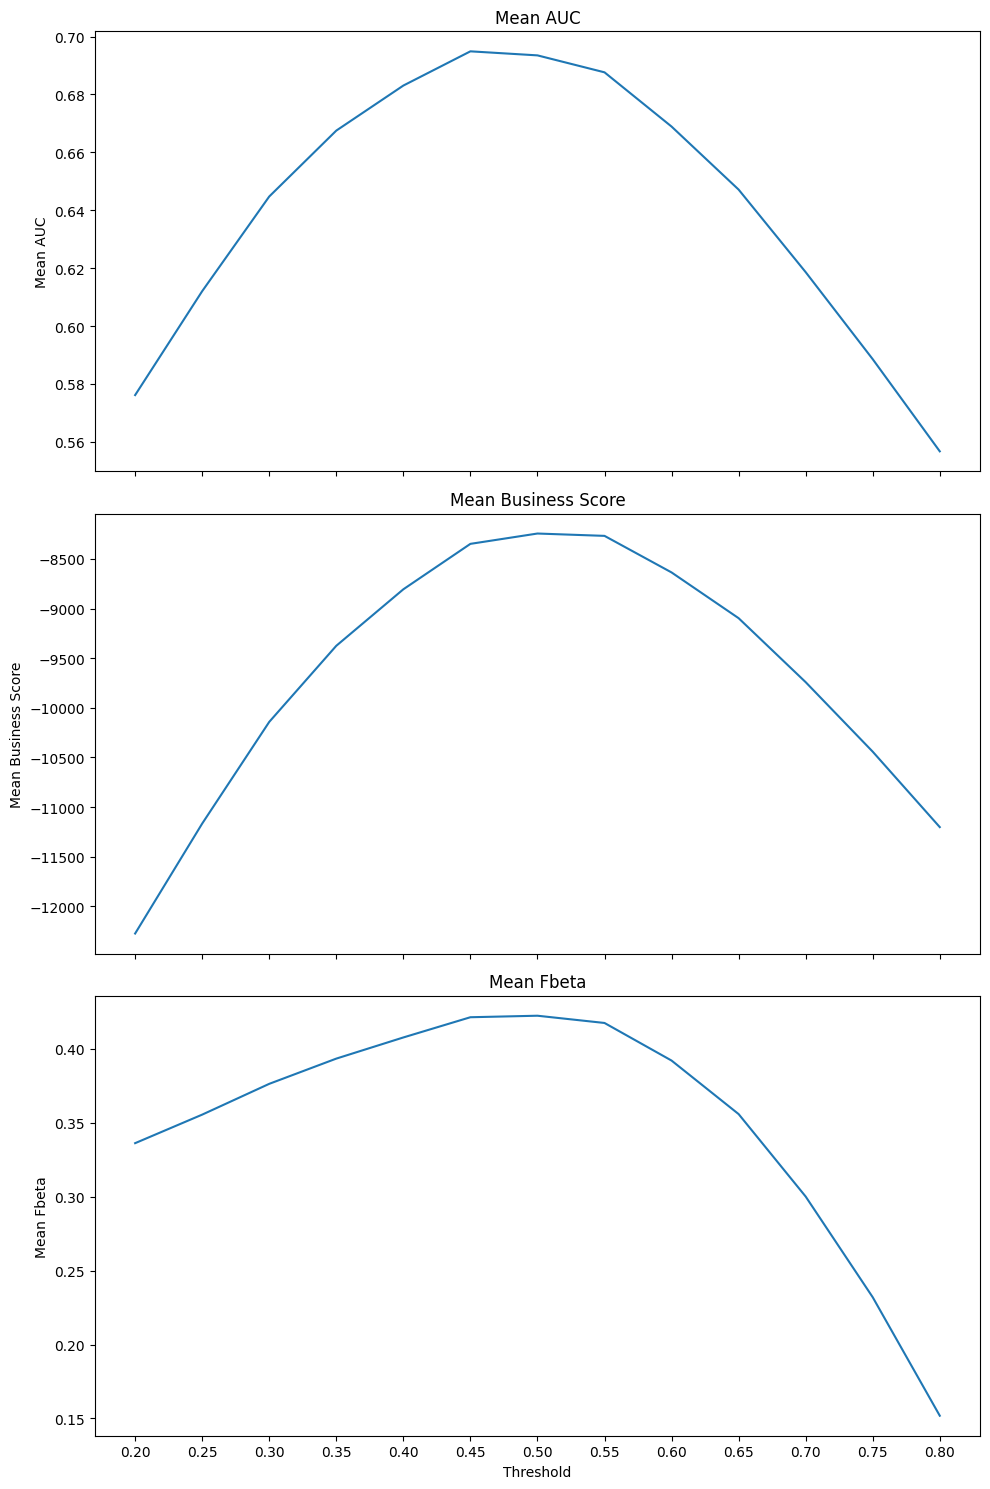

In [52]:
# Set up the figure with subplots
fig, axes = plt.subplots(nrows=3, ncols=1, figsize=(10, 15), sharex=True)

# Line plot for Mean AUC
sns.lineplot(x='Threshold', y='Mean_AUC', data=mean_results_df, ax=axes[0])
axes[0].set_title('Mean AUC')
axes[0].set_ylabel('Mean AUC')

# Line plot for Mean Business Score
sns.lineplot(x='Threshold', y='Mean_Business_Score', data=mean_results_df, ax=axes[1])
axes[1].set_title('Mean Business Score')
axes[1].set_ylabel('Mean Business Score')

# Line plot for Mean Fbeta
sns.lineplot(x='Threshold', y='Mean_Fbeta', data=mean_results_df, ax=axes[2])
axes[2].set_title('Mean Fbeta')
axes[2].set_ylabel('Mean Fbeta')

# Set x-axis labels explicitly
threshold_labels = mean_results_df['Threshold'].tolist()
axes[-1].set_xticks(threshold_labels)
axes[-1].set_xticklabels([f'{val:.2f}' for val in threshold_labels])  # Format threshold values
axes[-1].set_xlabel('Threshold')

# Adjust layout
plt.tight_layout()

# Show the plots
plt.show()

# Variables globales et locales

[12:08:54] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0cec3277c4d9d0165-1\xgboost\xgboost-ci-windows\src\c_api\c_api.cc:1240: Saving into deprecated binary model format, please consider using `json` or `ubj`. Model format will default to JSON in XGBoost 2.2 if not specified.
100%|===================| 116346/116422 [05:55<00:00]        

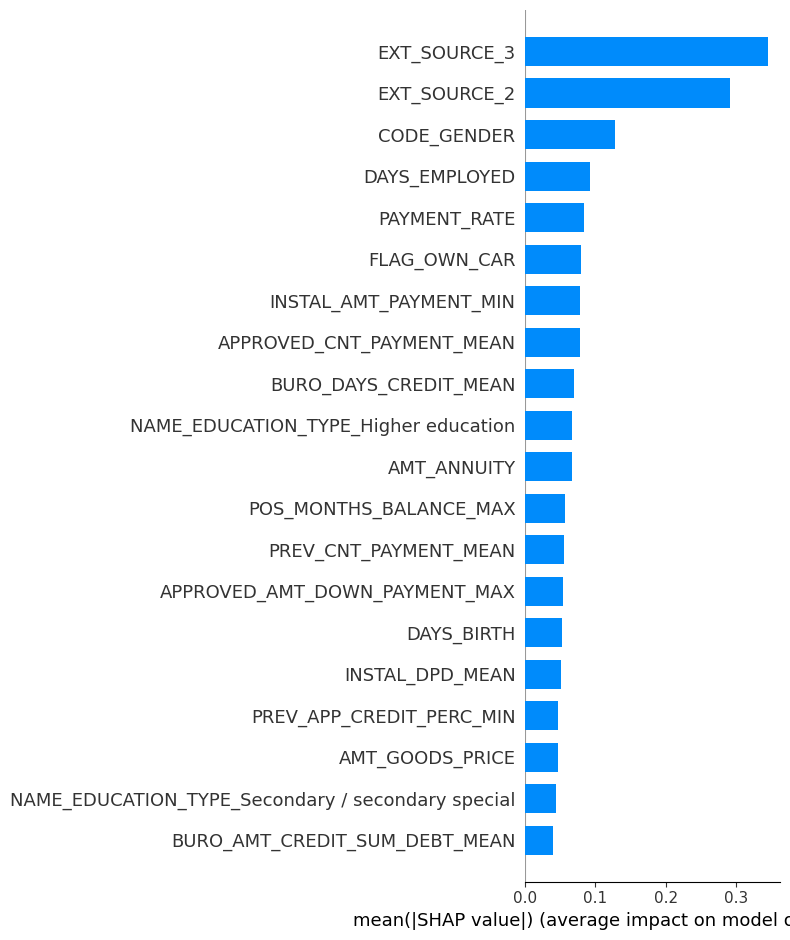

In [53]:
import shap
shap.initjs()  # Initialize JavaScript visualization for plots

# Assuming you have a trained model, e.g., xgb_regressor
explainer = shap.Explainer(model, X_train_scaled)  # Create an explainer object

# Calculate global variable importances
shap_values = explainer.shap_values(X_train_scaled)

# Summary plot (global variable importance)
shap.summary_plot(shap_values, X, plot_type="bar")

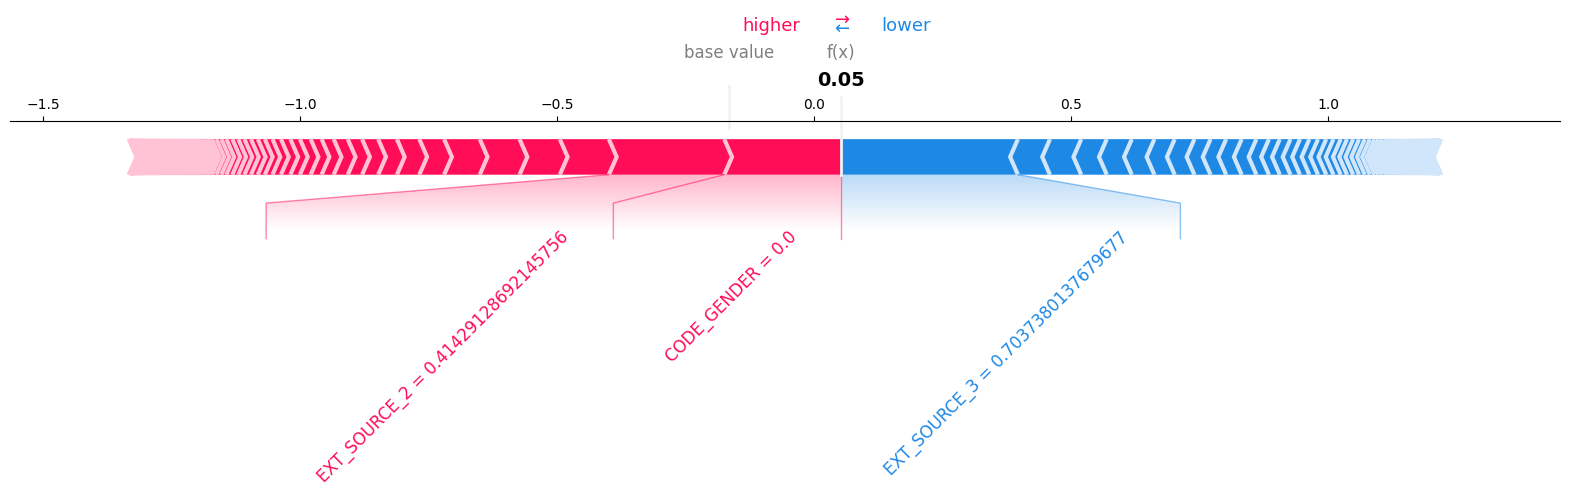

In [54]:
# Assuming you have 'explainer' and 'shap_values' previously defined

# Choose a specific data point for which you want to explain the prediction
instance_index = 0  # Replace with the index of the data point you're interested in

# Create a local explanation plot
shap.force_plot(explainer.expected_value, shap_values[instance_index], X_train_scaled[instance_index, :], matplotlib=True, feature_names=X.columns, text_rotation=45)

# Feature Importance

In [55]:
# Assuming you have a trained XGBoost model named 'xgb_regressor'
feature_importances = model.feature_importances_

# Create a list of feature names (assuming you have them in the same order)
feature_names = X.columns.tolist()

# Create a DataFrame to store feature names and their importances
importance_df = pd.DataFrame({'Feature': feature_names, 'Importance': feature_importances})

# Sort the DataFrame by importance in descending order
importance_df = importance_df.sort_values(by='Importance', ascending=False)

# Print or visualize the feature importances
print(importance_df)

                                               Feature  Importance
30                                        EXT_SOURCE_3    0.050357
29                                        EXT_SOURCE_2    0.020263
202                              BURO_DAYS_CREDIT_MEAN    0.018485
80                NAME_EDUCATION_TYPE_Higher education    0.018093
359            PREV_NAME_CONTRACT_STATUS_Approved_MEAN    0.011793
361             PREV_NAME_CONTRACT_STATUS_Refused_MEAN    0.011628
490                      APPROVED_AMT_DOWN_PAYMENT_MAX    0.011172
542                             INSTAL_AMT_PAYMENT_MIN    0.009938
83   NAME_EDUCATION_TYPE_Secondary / secondary special    0.009926
10                                       DAYS_EMPLOYED    0.009712
419                  PREV_NAME_GOODS_CATEGORY_XNA_MEAN    0.009669
298                          PREV_APP_CREDIT_PERC_MEAN    0.009587
62                       NAME_CONTRACT_TYPE_Cash loans    0.009248
223                     BURO_CREDIT_ACTIVE_Closed_MEAN    0.00

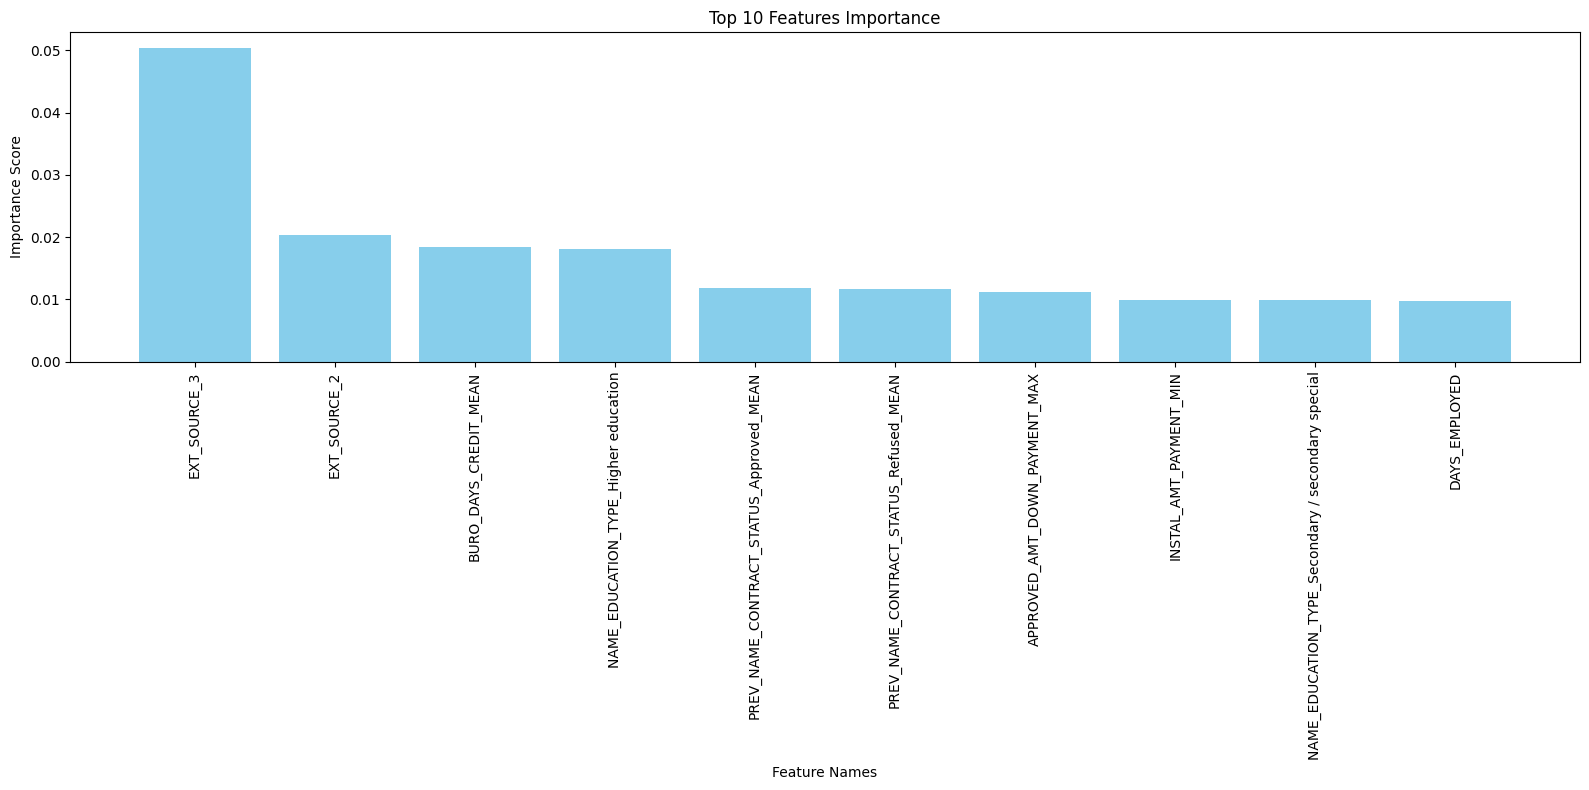

In [56]:
top_10_features = importance_df.head(10)

# Create a bar plot
plt.figure(figsize=(16, 8))
plt.bar(top_10_features['Feature'], top_10_features['Importance'], color='skyblue')
plt.xlabel('Feature Names')
plt.ylabel('Importance Score')
plt.title('Top 10 Features Importance')
plt.xticks(rotation=90)
plt.tight_layout()

# Show the plot
plt.show()

tout relancer avec le nouveau split df_train et df_predict (qu'on utilisera pour tester l'api) (OK), en inversant min max et sampling, greater is better = True (OK),
créer un repo sur github, le connecter avec vscode (OK), 
commencer à déveloper un script pour l'api en utilisat flask, et interface hyper simple pour la teser en utilisant streamlit (NOK)
analyser le drift en utilisant evidently (NOK)

In [35]:
# Charger les datasets
train_data = df_train
test_data = df_predict_cleaned

# Assurez-vous que les colonnes sont identiques dans les deux datasets
common_features = list(set(train_data.columns) & set(test_data.columns))  # Convert to list
train_data = train_data[common_features]
test_data = test_data[common_features]

# Prétraitement des données
X_train = train_data.drop(columns=['TARGET'])
y_train = train_data[['TARGET']]

# Utiliser RandomOverSampler pour gérer le déséquilibre de classe
oversampler = RandomOverSampler(random_state=42)
X_train_resampled, y_train_resampled = oversampler.fit_resample(X_train, y_train)


# Normaliser les données resamplées avec Min-Max Scaler
scaler = MinMaxScaler()
X_train_resampled_normalized = scaler.fit_transform(X_train_resampled)
#on enregistrre le scaler au format pickle
scaler on save en pickle
with open('scaler.pkl', 'wb') as file:
    pickle.dump(scaler, file)

# Entraîner le modèle XG Boost avec les données normalisées
model = XGBClassifier()
model.fit(X_train_resampled_normalized, y_train_resampled)#après cet étape, enregister le model en utilisant picke
pickle.dump('model.pkl')
with open('model.pkl', 'wb') as file:
    pickle.dump(model, file)

#Enregistrer (csv ou pickle ou parquet), le test_data AVEC ID sans normalisation

# Prétraitement des données de test
X_test = test_data.drop(columns=['TARGET'])  # Ne pas inclure la colonne Target dans les features

# Normaliser les données de test avec Min-Max Scaler
X_test_normalized = scaler.transform(X_test)


# Obtenir les probabilités de prédiction
probabilities = model.predict_proba(X_test_normalized)[:, 1]

# Appliquer le seuil de probabilité optimal (0.35)
threshold = 0.45
predictions = (probabilities > threshold).astype(int)
y_test = pd.DataFrame(predictions, columns=['TARGET'])


# Analyse du Data Drift avec Evidently
reference_data = {'prediction': y_train, 'data': X_train}
current_data = {'prediction': y_test, 'data': X_test}

report = Report(metrics=[
    DataDriftPreset(), 
])

report.run(reference_data=reference_data, current_data=current_data)
report



#On cré un dashboard streamlit hypersimple dans lequel on lmit le test_data, on selectionne une ligne avec la colonne SK_ID_..., on envoius la ligne sans l'id à l'api, on fait la prédiction côté api on renvoi le resultat au dashboard et on affiche le resultat

ValueError: PandasEngine works only with pd.DataFrame input data

In [57]:
type(X_test)

pandas.core.frame.DataFrame

In [ ]:
#Sauvegarder le modèle final entrainé au format pickle, sauvegarder les données test (application_test, on test csv, puis pickle ou parquet) ensuite s'en sert dans l'api